In [2]:
pip install roman

In [3]:
import os
import time
import pandas as pd
from bs4 import BeautifulSoup, NavigableString
import re
import requests
from urllib.parse import unquote
import roman
import matplotlib.pyplot as plt

In [4]:
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
import seaborn as sns
import random
from copy import deepcopy
from tqdm import tqdm
import gc

In [5]:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
import shap

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. СОЗДАНИЕ КОРПУСА ЛИТЕРАТУРНЫХ ТЕКСТОВ**

**1.1. Парсинг литературных текстов из LatinISE**

In [ ]:
def parse_latin_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    soup = BeautifulSoup(content, 'html.parser')
    data = []

    for doc in soup.find_all('doc'):
        doc_id = doc.get('id', '')
        doc_n = doc.get('n', '')
        doc_author = doc.get('author', '')
        doc_date = doc.get('date', '')
        doc_century = doc.get('century', '')
        doc_title = doc.get('title', '')
        doc_genre = doc.get('genre', '')
        doc_url = doc.get('url', '')

        full_text = []

        # Обрабатываем все элементы, содержащие текст
        for element in doc.find_all(['line', 's', 'p', 'book']):
            element_text = element.get_text(' ', strip=True)

            # Обрабатываем табуляции - берем только первый столбец
            lines = element_text.split('\n')
            for line in lines:
                if line.strip():
                    # Берем текст до первой табуляции
                    token = line.split('\t')[0].strip()
                    if token:
                        full_text.append(token)

        text = ' '.join(full_text)
        # Удаляем лишние пробелы
        text = ' '.join(text.split())

        data.append({
            'text': text,
            'id': doc_id,
            'n': doc_n,
            'author': doc_author,
            'date': doc_date,
            'century': doc_century,
            'title': doc_title,
            'genre': doc_genre,
            'url': doc_url
        })

    return pd.DataFrame(data)

In [ ]:
file_path = '/content/drive/MyDrive/DIPLOMA/latin14.txt'
latin_ise = parse_latin_file(file_path)

In [ ]:
latin_ise

text    id        n  \
0     Te formose Mida iam dudum nostra requirunt da ...    LC       10   
1     Olim tibi hos libellos Mavorti decus nostrum m...    LC       11   
2     In animo mihi est Diocletiane Auguste tot prin...    LC       12   
3     Fato rem publicam regi eamque nunc ad summum e...    LC       12   
4     Disciplina a discendo nomen accepit unde et sc...    LC       14   
...                                                 ...   ...      ...   
1250  Solus in antiquo fulgebat clara potestas caeli...  MQDQ      565   
1251  Actus euangelii confirmant gesta priora facit ...  MQDQ      566   
1252  Summe et sancte deus cunctae uirtutis origo qu...  MQDQ      189   
1253  Erexit fautore Deo rex inclytus urbem suae cel...  MQDQ      616   
1254  IN NOMINE DOMINI NOSTRI IESU CHRISTI CAESAR FL...    IT  LAT0202   

                                                 author           date  \
0                                             uncertain       01 cent.   
1                              Iulius Firmicus Maternus       04 cent.   
2                                             uncertain    04-05 cent.   
3                                             uncertain    04-05 cent.   
4                        Isidorus Hispalensis Episcopus    06-07 cent.   
...                                                 ...            ...   
1250                                         Victorinus  cent. 5 A. D.   
1251                                         Victorinus  cent. 5 A. D.   
1252                                      Marius Victor  cent. 5 A. D.   
1253                                            unknown  672-680 A. D.   
1254  Iustinianus, Caesar Flavius (Imperator Iustini...      533 A. D.   

              century                 title   genre  \
0       cent. 1 A. D.   Einsiedeln Eclogues  poetry   
1       cent. 4 A. D.  Matheseos libri VIII   prose   
2     cent. 4-5 A. D.      Historia Augusta   prose   
3     cent. 4-5 A. D.      Historia Augusta   prose   
4     cent. 6-7 A. D.           Etymologiae   prose   
...               ...                   ...     ...   
1250  cent. 4-5 A. D.        de lege domini  poetry   
1251  cent. 4-5 A. D.         de natiuitate  poetry   
1252  cent. 4-5 A. D.               alethia  poetry   
1253  cent. 5-7 A. D.   inscriptio Toletana  poetry   
1254    cent. 6 A. D.         Institutiones   prose   

                                                    url  
0     http://penelope.uchicago.edu/Thayer/E/Roman/ho...  
1     http://penelope.uchicago.edu/Thayer/E/Roman/ho...  
2     http://penelope.uchicago.edu/Thayer/E/Roman/ho...  
3     http://penelope.uchicago.edu/Thayer/E/Roman/ho...  
4     http://penelope.uchicago.edu/Thayer/E/Roman/ho...  
...                                                 ...  
1250                                                     
1251                                                     
1252          https://www.mqdq.it/texts/VICTOR|alet|000  
1253                                                     
1254  IntraText Digital Library http://www.intratext...  

[1255 rows x 9 columns]

In [ ]:
latin_ise['date'].unique()

array(['01 cent.', '04 cent.', '04-05 cent.', '06-07 cent.', '05 cent.',
       'cent. 1 B. C.', '02-03 cent.', '-01 cent.', 'ca.345-420A.D.',
       '522-526A.D.', 'ca.1225-1284A.D.', '397-401A.D.', '391(TPQ)',
       '1224A.D.', 'cent. 12 A. D.', '2000A.D.', '1517A.D.',
       '1547-1548A.D.', '1530A.D.', '1260ca.', 'cent. 13 A. D.',
       '1998A.D.', '43-34 B.C.', '2001A.D.', '1992A.D.', '158ca.',
       '49A.D.', '46 B.C.', 'cent. 1 B. C.-1 A.D.', '121(TPQ)', '37 B.C.',
       '199A.D.', '387A.D.', '197(TAQ)', 'cent. 1 A. D.', '62A.D.',
       '62-65A.D.', '43 B.C.', '58-59A.D.', '385ca.', '40A.D.', '81B.C.',
       '80B.C.', '62B.C.', '52 B.C.', '44 B.C.', '65(TAQ)', '100A.D.',
       '43A.D.', 'cent. 4 A. D.', '41-42A.D.', '53 B.C.', '113(TPQ)',
       '333ca.-392(TPQ)', '76B.C.', '66B.C.', '63B.C.', '69 B.C.',
       '59B.C.', '56B.C.', '55 B.C.', '45 B.C.', 'ca. 27-9 B.C.',
       '29-30 A.D.', 'cent. 8-9 A. D.', '64 B.C.', '56 B.C.', '66 B.C.',
       'ca. 205-184 B. C.', '63

**1.2. ПРЕОБРАЗОВАНИЕ ДАТ**

In [ ]:
def parse_date(date_str):
    lower_date = None
    upper_date = None
    mid_date = None
    century = None

    if not isinstance(date_str, str) or not date_str.strip():
        return lower_date, mid_date, upper_date, century

    date_str = re.sub(r'\s+', ' ', date_str.strip())

    def get_bc_status(s, elements):
        # Общий BC маркер после диапазона (например "2-3 B. C.")
        if re.search(r'B\.\s*C\.\s*$', s):
            return [True] * len(elements)

        # Индивидуальные маркеры
        bc_elements = []
        for elem in elements:
            elem_str = str(elem)
            if re.search(rf'(?:^|\D){elem_str}\s*B\.\s*C\.(?:\D|$)', s):
                bc_elements.append(True)
            else:
                bc_elements.append(False)
        return bc_elements

    # 1. Обработка веков (с указанием "cent.")
    if 'cent.' in date_str.lower():
        # Извлекаем все числа, связанные с веками
        century_numbers = []
        century_matches = re.finditer(r'(-?\d+)(?:\s*([/-])\s*(-?\d+))?', date_str)

        for match in century_matches:
            if match.group(1):
                century_numbers.append(int(match.group(1)))
                if match.group(2) and match.group(3):  # Если есть диапазон веков
                    century_numbers.append(int(match.group(3)))

        if century_numbers:
            bc_status = get_bc_status(date_str, century_numbers)
            century_ranges = []

            for cent, is_bc in zip(century_numbers, bc_status):
                # Вычисляем границы века
                abs_cent = abs(cent)
                lower = (abs_cent - 1) * 100 + 1
                upper = abs_cent * 100
                if is_bc:
                    lower, upper = -upper, -lower

                century_ranges.append((lower, upper))

            if century_ranges:
                # Вычисляем общий диапазон
                lower_date = min(r[0] for r in century_ranges)
                upper_date = max(r[1] for r in century_ranges)
                mid_date = (lower_date + upper_date) // 2


    # 2. Обработка числовых дат (если не было обработки веков)
    else:
        numbers = []
        # Извлечение чисел (игнорируя даты после "/")
        for num_match in re.finditer(r'(?<!\/)(-?\d+)(?![\d\/])', date_str):
            num = int(num_match.group(1))
            numbers.append(num)

        if numbers:
            bc_status = get_bc_status(date_str, numbers)
            processed_numbers = []

            for num, is_bc in zip(numbers, bc_status):
                processed_numbers.append(-abs(num) if is_bc else abs(num))

            if processed_numbers:
                # Для диапазона дат
                if '-' in date_str and len(processed_numbers) > 1:
                    # Убедимся, что даты в правильном порядке
                    processed_numbers.sort()
                    lower_date = processed_numbers[0]
                    upper_date = processed_numbers[-1]
                else:
                    lower_date = upper_date = processed_numbers[0]

                mid_date = (lower_date + upper_date) // 2

    if mid_date == 0:
        mid_date = -1

    # 3. Вычисление века по mid_date (в римских цифрах)
    if mid_date is not None and century is None:
        abs_date = abs(mid_date)
        century_num = (abs_date - 1) // 100 + 1
        if mid_date < 0:
            century = f"-{century_num}"
        else:
            century = str(century_num)

    return lower_date, mid_date, upper_date, century

In [ ]:
cleaned_ise = latin_ise.copy()

cleaned_ise[['lower_date', 'mid_date', 'upper_date', 'century']] = latin_ise['date'].apply(
    lambda x: pd.Series(parse_date(x))
)

for col in ['lower_date', 'mid_date', 'upper_date']:
    cleaned_ise[col] = pd.to_numeric(cleaned_ise[col], errors='coerce')

In [ ]:
cleaned_ise = cleaned_ise[~(cleaned_ise['date'] == '')]

In [ ]:
cleaned_ise['century'].unique()

array(['1', '4', '6', '5', '-1', '2', '13', '12', '20', '16', '21', '8',
       '-2', '3', '15', '-7', '-4', '14', '-5', '9', '10', '11', '18',
       '19', '17', '7', '-3'], dtype=object)

In [ ]:
len(cleaned_ise)

1247

In [ ]:
output_path = '/content/drive/MyDrive/DIPLOMA/CORPORA/cleaned_ise.csv'
cleaned_ise.to_csv(output_path, index=False, encoding='utf-8-sig')

In [ ]:
cleaned_ise = pd.read_csv('/content/drive/MyDrive/DIPLOMA/CORPORA/cleaned_ise.csv')

**2. СОЗДАНИЕ КОРПУСА НЕЛИТЕРАТУРНЫХ ЛАТИНСКИХ ТЕКСТОВ**

**2.1. Парсинг текстов в xml-разметке из PAPYRI.INFO**

In [ ]:
FOLDER = '/content/drive/MyDrive/DIPLOMA/PAPYRI'
DELAY = 3
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}


def sanitize_filename(filename):
    filename = unquote(filename)
    filename = re.sub(r'[\\/*?:"<>|;]', "_", filename)
    return filename


def save_xml(url, content):
    filename = sanitize_filename(url.split('/')[-2]) + '.xml'
    filename = os.path.join(FOLDER, filename)
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(content)
    print(f"Сохранено: {filename}")


def get_page(url):
    time.sleep(DELAY)
    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()
        return response.text
    except requests.RequestException as e:
        print(f"Ошибка при загрузке {url}: {e}")
        return None


def parse_papyrus_page(papyrus_url):
    html = get_page(papyrus_url)
    if not html:
        return

    soup = BeautifulSoup(html, 'html.parser')

    xml_link = soup.select_one('.transcription h2 a') # Путь здесь и далее определн при помощи расширения SelectorGadjet
    if not xml_link:
        print(f"Не найдена XML ссылка на {papyrus_url}")
        return

    xml_url = xml_link['href']
    xml_url = 'https://papyri.info' + xml_url
    print(f"Найдена XML ссылка: {xml_url}")

    xml_content = get_page(xml_url)
    if xml_content:
        save_xml(xml_url, xml_content)


def parse_search_page(page_url):
    html = get_page(page_url)
    if not html:
        return

    soup = BeautifulSoup(html, 'html.parser')

    identifiers = soup.select('.identifier a')
    print(f"Найдено {len(identifiers)} папирусов")

    for ident in identifiers:
        papyrus_url = ident['href']
        papyrus_url = 'https://papyri.info' + papyrus_url
        print(f"\nОбрабатываем: {papyrus_url}")
        parse_papyrus_page(papyrus_url)


In [ ]:
def main_page1():

    # Базовый URL поиска в PAPIRY.INFO по первой странице
    base_url = "https://papyri.info/search?DATE_MODE=LOOSE&DATE_START_TEXT=300&DATE_START_ERA=BCE&DOCS_PER_PAGE=999&LANG=la&TRANSC=true"
    parse_search_page(base_url)


if __name__ == "__main__":
    main_page1()

In [ ]:
def main_page2():

    # Базовый URL поиска в PAPIRY.INFO по второй странице
    base_url = "https://papyri.info/search?DATE_START_TEXT=300&DATE_START_ERA=BCE&DATE_MODE=LOOSE&LANG=la&TRANSC=true&DOCS_PER_PAGE=999&page=2"
    parse_search_page(base_url)


if __name__ == "__main__":
    main_page2()

Найдено 570 папирусов

Обрабатываем: https://papyri.info/ddbdp/pap.congr.26;;352?rows=3&start=1242&fl=id,title&fq=has_transcription:true&fq=facet_language:la&fq=latest_date:%5B-300+TO+2500%5D&sort=series+asc,volume+asc,item+asc&p=1243&t=1568
Найдена XML ссылка: https://papyri.info/ddbdp/pap.congr.26;;352/source
Сохранено: /content/drive/MyDrive/DIPLOMA/PAPYRI/pap.congr.26__352.xml

Обрабатываем: https://papyri.info/ddbdp/pap.congr.27;;933_1?rows=3&start=1243&fl=id,title&fq=has_transcription:true&fq=facet_language:la&fq=latest_date:%5B-300+TO+2500%5D&sort=series+asc,volume+asc,item+asc&p=1244&t=1568
Найдена XML ссылка: https://papyri.info/ddbdp/pap.congr.27;;933_1/source
Сохранено: /content/drive/MyDrive/DIPLOMA/PAPYRI/pap.congr.27__933_1.xml

Обрабатываем: https://papyri.info/ddbdp/pap.congr.27;;938_2?rows=3&start=1244&fl=id,title&fq=has_transcription:true&fq=facet_language:la&fq=latest_date:%5B-300+TO+2500%5D&sort=series+asc,volume+asc,item+asc&p=1245&t=1568
Найдена XML ссылка: https:

**2.2. Создание датасета документов**

In [ ]:
def extract_xml_data(filepath):
    filename = os.path.basename(filepath)
    with open(filepath, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'xml')

        # Извлекаем location
        place_name = soup.find('placeName') if soup.head else None
        if place_name:
            location = place_name.get_text()
        else:
            orig_place = soup.find('origPlace')
            location = orig_place.get_text() if orig_place else None

        # Извлекаем date
        head_date = soup.find('date') if soup.head else None
        if head_date:
            date = head_date.get_text()
        else:
            orig_date = soup.find('origDate')
            date = orig_date.get_text() if orig_place else None

        # Извлекаем material
        material_tag = soup.find('material')
        material = material_tag.get_text() if material_tag else None

        # Извлекаем text (сохраняем всю внутреннюю разметку)
        text_tag = soup.find('text')
        text = str(text_tag) if text_tag else None

        print(f"\nОбработан файл: {filename}")
        print(f"Дата: {date if date else 'Не указана'}")
        print(f"Место: {location if location else 'Не указано'}")
        print(f"Материал: {material if material else 'Не указан'}")

        return {
            'filename': filename,
            'text': text,
            'date': date,
            'location': location,
            'material': material
        }


data = []
base_path = '/content/drive/MyDrive/DIPLOMA/PAPYRI'

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.xml'):
            filepath = os.path.join(root, file)
            try:
                file_data = extract_xml_data(filepath)
                data.append(file_data)
            except Exception as e:
                print(f"Ошибка при обработке файла {file}: {str(e)}")
                continue

latin_papyri = pd.DataFrame(data)
latin_papyri = latin_papyri[['filename', 'text', 'date', 'location', 'material']]

output_path = '/content/drive/MyDrive/DIPLOMA/CORPORA/latin_papyri.csv'
latin_papyri.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"Обработка завершена. Сохранено {len(latin_papyri)} записей в {output_path}")

Выходные данные были обрезаны до нескольких последних строк (5000).

Обработан файл: p.tebt_3.1_815.xml
Дата: 228-221 BC
Место: Tebtynis
Материал: Не указан
Размер текста: 121952 символов

Обработан файл: p.tebt_3.2_834.xml
Дата: III/II sac
Место: Tebtynis
Материал: Не указан
Размер текста: 14564 символов

Обработан файл: p.tebt_3.2_848.xml
Дата: II sac
Место: Tebtynis
Материал: Не указан
Размер текста: 61204 символов

Обработан файл: p.tebt_3.2_850.xml
Дата: 170 BC
Место: Tebtynis
Материал: Не указан
Размер текста: 14309 символов

Обработан файл: p.tebt_3.2_855.xml
Дата: II sac
Место: Tebtynis
Материал: Не указан
Размер текста: 15162 символов

Обработан файл: p.tebt_3.2_867.xml
Дата: III sac
Место: Tebtynis
Материал: Не указан
Размер текста: 42865 символов

Обработан файл: p.tebt_3.2_874.xml
Дата: 179 BC
Место: Tebtynis
Материал: Не указан
Размер текста: 2284 символов

Обработан файл: p.tebt_3.2_887.xml
Дата: II sac
Место: Tebtynis
Материал: Не указан
Размер текста: 24110 символов

Об

In [ ]:
latin_papyri = pd.read_csv('/content/drive/MyDrive/DIPLOMA/CORPORA/latin_papyri.csv')

**2.3. Очистка датасета от текстов преимущественно на древнегреческом или без даты**

In [ ]:
def contains_greek_div(xml_text):
    soup = BeautifulSoup(xml_text, 'lxml-xml')
    greek_divs = soup.find_all('div', {'xml:lang': 'grc'})
    return len(greek_divs) > 0

filtered_papyri = latin_papyri[~latin_papyri['text'].apply(contains_greek_div)].copy()

In [ ]:
len(filtered_papyri)

754

In [ ]:
undefined_dates = filtered_papyri[filtered_papyri['date'].isna()].copy()

In [ ]:
# Исправляем неточности при изначальном парсинге (дата не была указана в xml текста)
def find_date_for_filename(filename):
    filename = re.sub(r'_+', ' ', re.sub(r'\.xml$', '', filename, flags=re.IGNORECASE))
    base_url = "https://papyri.info/search?DATE_START_TEXT=300&DATE_START_ERA=BCE&DATE_MODE=LOOSE&LANG=la&TRANSC=true&DOCS_PER_PAGE=999&page="

    for page in range(1, 3):
        search_url = base_url + str(page)

        try:
            response = requests.get(search_url, timeout=10)
            response.raise_for_status()

            soup = BeautifulSoup(response.text, 'html.parser')

            identifiers = soup.select('.identifier')

            for identifier in identifiers:
                if identifier and filename in identifier.text.strip():
                    link = identifier.find('a', href=True)
                    if link:
                        doc_url = "https://papyri.info" + link['href']
                        return extract_date_from_document(doc_url)

            time.sleep(2)  # Задержка между запросами

        except Exception as e:
            print(f"Ошибка при обработке страницы {page}: {e}")
            time.sleep(5)
            continue

    return None  # Если не нашли ни на одной странице

# Функция для извлечения даты из документа
def extract_date_from_document(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')
        date_cell = soup.select('.mddate')

        if date_cell:
          for date in date_cell:
            date = date.get_text(strip=True)
            date = re.search(r'^(.*?)\s*More', date, re.DOTALL).group(1).strip()
            return date

    except Exception as e:
        print(f"Ошибка при извлечении даты из {url}: {e}")

    return None

In [ ]:
for index, row in undefined_dates.iterrows():
        filename = row['filename']
        print(f"Обрабатываю {filename}...")

        date = find_date_for_filename(filename)

        if date:
            undefined_dates.at[index, 'date'] = date
            print(f"Найдена дата для {filename}: {date}")
        else:
            print(f"Дата для {filename} не найдена")

Обрабатываю o.claud_4_843.xml...
Найдена дата для o.claud_4_843.xml: ca. 138 - 161
Обрабатываю o.claud_4_845.xml...
Найдена дата для o.claud_4_845.xml: ca. 138 - 161
Обрабатываю o.claud_4_846.xml...
Найдена дата для o.claud_4_846.xml: ca. 98 - 117
Обрабатываю o.claud_4_847.xml...
Найдена дата для o.claud_4_847.xml: ca. 98 - 117
Обрабатываю o.did__47.xml...
Найдена дата для o.did__47.xml: vor (?)
                                       ca. 88 - 96
Обрабатываю o.did__63.xml...
Найдена дата для o.did__63.xml: vor (?)
                                       ca. 88 - 96
Обрабатываю o.did__179.xml...
Найдена дата для o.did__179.xml: vor (?)
                                       ca. 100 - 110
Обрабатываю o.did__204.xml...
Найдена дата для o.did__204.xml: vor (?)
                                       ca. 77 - 92
Обрабатываю o.did__205.xml...
Найдена дата для o.did__205.xml: vor (?)
                                       ca. 77 - 92
Обрабатываю o.did__206.xml...
Найдена дата для o.did__206.xml:

In [ ]:
undefined_dates

filename                                               text  \
70       o.claud_4_843.xml  <text>\n<body>\n<head xml:lang="en"/>\n<div ty...   
71       o.claud_4_845.xml  <text>\n<body>\n<head xml:lang="en"/>\n<div ty...   
72       o.claud_4_846.xml  <text>\n<body>\n<head xml:lang="en"/>\n<div ty...   
73       o.claud_4_847.xml  <text>\n<body>\n<head xml:lang="en"/>\n<div ty...   
74           o.did__47.xml  <text>\n<body>\n<head xml:lang="en"/>\n<div ty...   
...                    ...                                                ...   
1417  o.berenike_3_416.xml  <text>\n<body>\n<head xml:lang="en"/>\n<div ty...   
1419  o.berenike_3_433.xml  <text>\n<body>\n<head xml:lang="en"/>\n<div ty...   
1420  o.berenike_3_439.xml  <text>\n<body>\n<head xml:lang="en"/>\n<div ty...   
1421  o.berenike_3_478.xml  <text>\n<body>\n<head xml:lang="en">\n<ref n="...   
1422  o.berenike_4_527.xml  <text>\n<body>\n<div type="edition" xml:lang="...   

                                                   date location material  
70                                        ca. 138 - 161      NaN      NaN  
71                                        ca. 138 - 161      NaN      NaN  
72                                         ca. 98 - 117      NaN      NaN  
73                                         ca. 98 - 117      NaN      NaN  
74    vor (?)\n                                     ...      NaN      NaN  
...                                                 ...      ...      ...  
1417                                        2. Hälfte I      NaN      NaN  
1419                                        2. Hälfte I      NaN      NaN  
1420                                        2. Hälfte I      NaN      NaN  
1421                                        2. Hälfte I      NaN      NaN  
1422                                        2. Hälfte I      NaN      NaN  

[140 rows x 5 columns]

In [ ]:
date_mapping = dict(zip(undefined_dates['filename'], undefined_dates['date']))
filtered_papyri['date'] = filtered_papyri['filename'].map(date_mapping).fillna(filtered_papyri['date'])

In [ ]:
filtered_papyri = filtered_papyri[~filtered_papyri['date'].isna()]

**2.4. Обработка текста**

In [ ]:
def clean_papyri_text(xml_text):

    soup = BeautifulSoup(xml_text, 'xml')

    # Находим div с xml:lang="la"
    main_div = soup.find('div', {'type': 'edition'})

    result_parts = []

    # Функция для рекурсивного поиска и обработки ab
    def process_element(element):
        nonlocal result_parts
        if element.name == 'ab':
            div_text_parts = []
            prev_was_gap = False

            for content in element.contents:
                processed, is_gap = process_content(content)
                if processed:
                    if prev_was_gap and div_text_parts:
                        div_text_parts.append('_')
                    div_text_parts.append(processed)
                prev_was_gap = is_gap

            div_text = ''.join(div_text_parts)
            if div_text:
                result_parts.append(div_text)

        elif element.name == 'div':
            # Обрабатываем только div с type="textpart" или аналогичные, рекурсивно, пока не доберемся до <ab>
            if element.get('type') in ['textpart', None]:
                for child in element.children:
                    process_element(child)

    # Начинаем обработку с основного div
    for child in main_div.children:
        process_element(child)

    # Объединяем все части с разделителем "_"
    final_text = '_'.join(result_parts)
    return final_text

def process_content(content):
    # Игнорируем только указанные теги
    if content.name in ['rdg', 'reg', 'num']:
        return "", False

    # Обрабатываем теги gap и space (возвращаем флаг что был gap)
    if content.name in ['gap', 'space', 'foreign']:
        return "", True

    # Обрабатываем lb, handShift, g - просто игнорируем
    if content.name in ['lb', 'handShift', 'g']:
        return "", False

    # Обрабатываем теги с особым содержимым
    if content.name in ['supplied', 'unclear', 'abbr', 'expan', 'ex',
                       'subst', 'add', 'del', 'choice', 'app', 'lem', 'ab']:
        return process_children(content), False

    # Обрабатываем обычный текст
    if content.name is None:
        text = str(content).strip()
        # Удаляем лишние пробелы и переносы строк
        text = ' '.join(text.split())
        return text if text else "", False

    # Для всех остальных тегов рекурсивно обрабатываем детей
    return process_children(content), False

def process_children(tag):
    text_parts = []
    prev_was_gap = False

    for child in tag.children:
        processed, is_gap = process_content(child)
        if processed:
            if prev_was_gap and text_parts:
                text_parts.append('_')
            text_parts.append(processed)
        prev_was_gap = is_gap

    return ''.join(text_parts)

In [ ]:
cleaned_papyri = filtered_papyri.copy()
cleaned_papyri['text'] = filtered_papyri['text'].apply(clean_papyri_text)

In [ ]:
cleaned_papyri = cleaned_papyri.copy().reset_index(drop=True)
cleaned_papyri

filename                                               text  \
0    o.bu.njem__112.xml     erbariuathe_octo gipsat_accepitdenariosduos_ho   
1    o.bu.njem__113.xml  Augurinus Urtato fratri salutem_cifico tibi fr...   
2    o.bu.njem__114.xml  Aurelio Stesalutemsalutafratermeciano Satuisfi...   
3    o.bu.njem__115.xml                             plenullasimperilloeste   
4    o.bu.njem__116.xml  Germantessera_sedecimquam penes sexe_abesvacua...   
..                  ...                                                ...   
747  o.bu.njem__107.xml          Terentiuset decurioal_eorumrisimoprimtsli   
748  o.bu.njem__108.xml                suis prisfebrate bene bmultis annis   
749  o.bu.njem__109.xml  suo_PomponiusFelix die Idusnovemresopto tebone...   
750  o.bu.njem__110.xml  Luria Feliciaccepiliterasvitam per quemnobemqu...   
751  o.bu.njem__111.xml           bentes_ernare_erni_praeposito_am_cipis_t   

        date location material  
0    III spc    Golas      NaN  
1    III spc    Golas      NaN  
2    III spc    Golas      NaN  
3    III spc    Golas      NaN  
4    III spc    Golas      NaN  
..       ...      ...      ...  
747  III spc    Golas      NaN  
748  III spc    Golas      NaN  
749  III spc    Golas      NaN  
750  III spc    Golas      NaN  
751  III spc    Golas      NaN  

[752 rows x 5 columns]

**2.5. Обработка дат**

In [ ]:
def parse_date(date_str):
    lower_date = None
    upper_date = None
    mid_date = None
    century = None

    if not isinstance(date_str, str):
        return lower_date, mid_date, upper_date, century

    date_str = re.sub(r'\s+', ' ', date_str.strip())

    def get_bc_status(s, elements):
        # Общий BC маркер после диапазона (например "2-3 BC")
        if re.search(r'(?:BC|v\.Chr\.)\s*$', s):
            return [True] * len(elements)

        # Индивидуальные маркеры
        bc_elements = []
        for elem in elements:
            elem_str = str(elem)
            if re.search(rf'(?:^|\D){elem_str}\s*(?:BC|v\.Chr\.)(?:\D|$)', s):
                bc_elements.append(True)
            elif isinstance(elem, int) and re.search(rf'(?:^|\D)-{elem_str}(?:\D|$)', s):
                bc_elements.append(True)
            else:
                bc_elements.append(False)
        return bc_elements


    # 1. Обработка римских веков
    roman_match = re.finditer(r'([IVX]+)(?:\s*([/-])\s*([IVX]+))?', date_str)
    roman_centuries = []

    for match in roman_match:
        if match.group(2):  # Если есть разделитель между веками
            first = match.group(1)
            second = match.group(3)
            roman_centuries.extend([first, second])
        else:
            roman_centuries.append(match.group(1))

    if roman_centuries:
        bc_status = get_bc_status(date_str, roman_centuries)
        century_ranges = []

        for cent, is_bc in zip(roman_centuries, bc_status):
            # Вычисляем крайние даты для веков (century_ranges)
            try:
                cent_num = roman.fromRoman(cent.upper())
                if is_bc:
                    cent_num = -cent_num
                    lower = (abs(cent_num) - 1) * 100 + 1
                    upper = abs(cent_num) * 100
                    lower, upper = -upper, -lower
                else:
                    lower = (cent_num - 1) * 100 + 1
                    upper = cent_num * 100

                century_ranges.append((lower, upper))
            except roman.InvalidRomanNumeralError:
                continue

        if century_ranges:
            # Вычисляем общий диапазон для всех веков
            lower_date = min(r[0] for r in century_ranges)
            upper_date = max(r[1] for r in century_ranges)
            mid_date = (lower_date + upper_date) // 2


    # 2. Обработка числовых дат (только если не было римских веков)
    if not roman_centuries:
        numbers = []
        # Извлечение чисел (игнорируя даты типа "4. Febr.")
        for num_match in re.finditer(r'(?<!\.)(-?\d+)(?!\.\d)', date_str):
            num = int(num_match.group(1))
            numbers.append(num)

        if numbers:
            bc_status = get_bc_status(date_str, numbers)
            processed_numbers = []
            for num, is_bc in zip(numbers, bc_status):
                processed_numbers.append(-abs(num) if is_bc else abs(num))

            if processed_numbers:
                lower_date = min(processed_numbers)
                upper_date = max(processed_numbers)
                mid_date = (lower_date + upper_date) // 2


    # 4. Вычисление века для числовых дат
    if mid_date is not None and century is None:
      abs_date = abs(mid_date)
      century_num = (abs_date - 1) // 100 + 1
      if mid_date < 0:
          century = f"-{century_num}"
      else:
          century = str(century_num)

    return lower_date, mid_date, upper_date, century

In [ ]:
cleaned_papyri[['lower_date', 'mid_date', 'upper_date', 'century']] = cleaned_papyri['date'].apply(
    lambda x: pd.Series(parse_date(x))
)

for col in ['lower_date', 'mid_date', 'upper_date']:
    cleaned_papyri[col] = pd.to_numeric(cleaned_papyri[col], errors='coerce')

In [ ]:
cleaned_papyri.loc[cleaned_papyri['mid_date'] < 0]

filename                                               text  \
128         59721.xml  e_Fraxinus frangituratque abies consternitur a...   
129        942310.xml                                 filio_mentes_nidus   
130         59360.xml  est_qua_xti_teranom_usexus_mexs_ulere_nd_ner_d...   
132        382586.xml                                           Thessali   
133        942311.xml                                           via_sibi   
134        942312.xml  diem_illo idus dici_atrium_adornassi_amar_mina...   
136        942313.xml        avisibe_conversu_aetas_querelisacribus iris   
137        140303.xml  cumqu_maontisapraeconesupecuniam_cumpretio_omn...   
138        942314.xml                            navi_idem_isse dixisset   
140        942316.xml  scisse_sempernunc_ruuinae_sed descen_ipse pros...   
141         66487.xml  o_is_anf_pra_u_rp_samae_vit_amr_ateis_adm_es_e...   
142         66488.xml  allaee_mortuatempor_accusaindividsaepeitatpare...   
146        243965.xml                ntiquoque_init xenutritisnutntiso_k   
252   sb_20_15139.xml  DiaconusMacedoni suo salutem.Dissimulare non p...   
267         59474.xml  tristia nequitia_aLycori, tua.Fata mihi, Caesa...   
331  c.ep.lat__10.xml  SunerosChio suoplurimamsalutemsivalesbene estT...   
332  c.ep.lat__11.xml                              accepiartabasfrumenti   
432    chla_5_308.xml  Nonas Iuliasconductei ivassesxviNonistextoresi...   
591  chla_43_1241.xml  tur_enrus_oniusaut_eriaautlinumauctor eos_tuil...   

                                                  date  \
128                                           I v.Chr.   
129                                    199 v.Chr. - 79   
130                                           I v.Chr.   
132                                    200 v.Chr. - 79   
133                                    199 v.Chr. - 79   
134                                    199 v.Chr. - 79   
136                                    100 v.Chr. - 79   
137                                    100 v.Chr. - 79   
138                                    100 v.Chr. - 79   
140                                    100 v.Chr. - 79   
141  \n                Anfang 100 v.Chr. - 79\n    ...   
142                                     30 v.Chr. - 20   
146                                    100 - 30 v.Chr.   
252                                             5-2 BC   
267                                       I v.Chr. - I   
331                                       27 BC-AD 14?   
332                                              18 BC   
432                                            31-8 BC   
591                                            29-2 BC   

                                              location material  lower_date  \
128  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -100   
129  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -199   
130  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -100   
132  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -200   
133  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -199   
134  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -199   
136  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -100   
137  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -100   
138  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -100   
140  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -100   
141  Fundort: Herculaneum (Campania, Italy) - 1752;...  papyrus        -100   
142  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus         -30   
146  Fundort: Herculaneum (Campania, Italy); Schrei...  papyrus        -100   
252                                                  ?      NaN          -5   
267  Fundort: Primis (Aethiopia, Egypt); Schreibort...  papyrus        -100   
331                                        Oxyrhynchus      NaN    

In [ ]:
output_path = '/content/drive/MyDrive/DIPLOMA/CORPORA/cleaned_papyri.csv'
cleaned_papyri.to_csv(output_path, index=False, encoding='utf-8-sig')

In [ ]:
cleaned_papyri = pd.read_csv('/content/drive/MyDrive/DIPLOMA/CORPORA/cleaned_papyri.csv')

**3. ПОДГОТОВКА КОРПУСОВ**

**3.1. Размер полных корпусов по векам**

In [ ]:
cleaned_ise['century'] = cleaned_ise['century'].astype(int)
cleaned_papyri['century'] = cleaned_papyri['century'].astype(int)

# Удалим документы, содержащие только числа, из документального корпуса
cleaned_papyri = cleaned_papyri[~cleaned_papyri['text'].isna()]

In [ ]:
# Очищаем литературны корпус от слишком ранних (мало текстов) и слишком поздних текстов
cleaned_ise = cleaned_ise[~( (cleaned_ise['century'] < -2) | (cleaned_ise['century'] > 6) )]

In [ ]:
# Подсчитываем количество текстов в литературном корпусе по векам
cleaned_ise['century'].value_counts().sort_index(ascending=True)

century
-2     73
-1    164
 1    157
 2     43
 3     49
 4    222
 5     80
 6     91
Name: count, dtype: int64

In [ ]:
# подсчитываем количесвто символов в литературном корпусе
cleaned_ise['num_chars'] = cleaned_ise['text'].str.len()

In [ ]:
cleaned_ise.groupby('century')['num_chars'].sum().reset_index()

century  num_chars
0       -2    2954854
1       -1   22285528
2        1   15965083
3        2    7295310
4        3    4236199
5        4   16296388
6        5  134832230
7        6   10876323

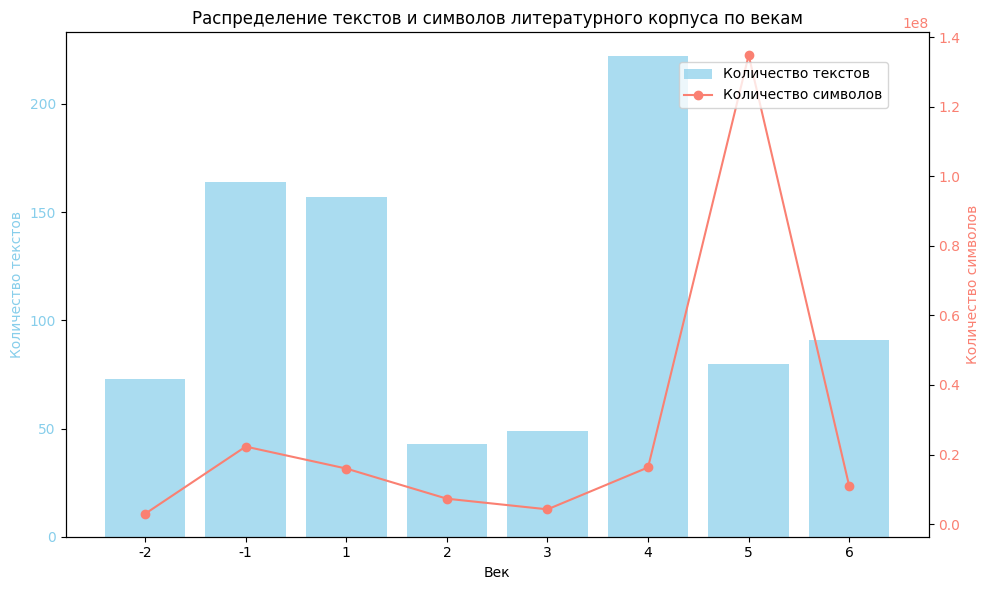

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

text_counts = cleaned_ise['century'].value_counts().sort_index(ascending=True)
char_counts = cleaned_ise.groupby('century')['num_chars'].sum().reset_index()

centuries = text_counts.index.astype(str)

ax1.bar(centuries, text_counts.values, color='skyblue', alpha=0.7, label='Количество текстов')
ax1.set_xlabel('Век')
ax1.set_ylabel('Количество текстов', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
ax2.plot(centuries, char_counts['num_chars'], color='salmon', marker='o', label='Количество символов')
ax2.set_ylabel('Количество символов', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

plt.title('Распределение текстов и символов литературного корпуса по векам')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

______________________________________________________________________________________________

In [ ]:
# Подсчитываем количество текстов в документальном корпусе по векам
cleaned_papyri['century'].value_counts().sort_index(ascending=True)

century
-1     19
 1    114
 2    183
 3    274
 4     47
 5     47
 6     16
 7      2
 8      1
Name: count, dtype: int64

In [ ]:
# подсчитываем количесвто символов в документальном корпусе
cleaned_papyri['num_chars'] = cleaned_papyri['text'].str.len()

In [ ]:
cleaned_papyri.groupby('century')['num_chars'].sum().reset_index()

century  num_chars
0       -1       8159
1        1      24842
2        2      68373
3        3     103556
4        4      14867
5        5      23426
6        6       8483
7        7        882
8        8       1594

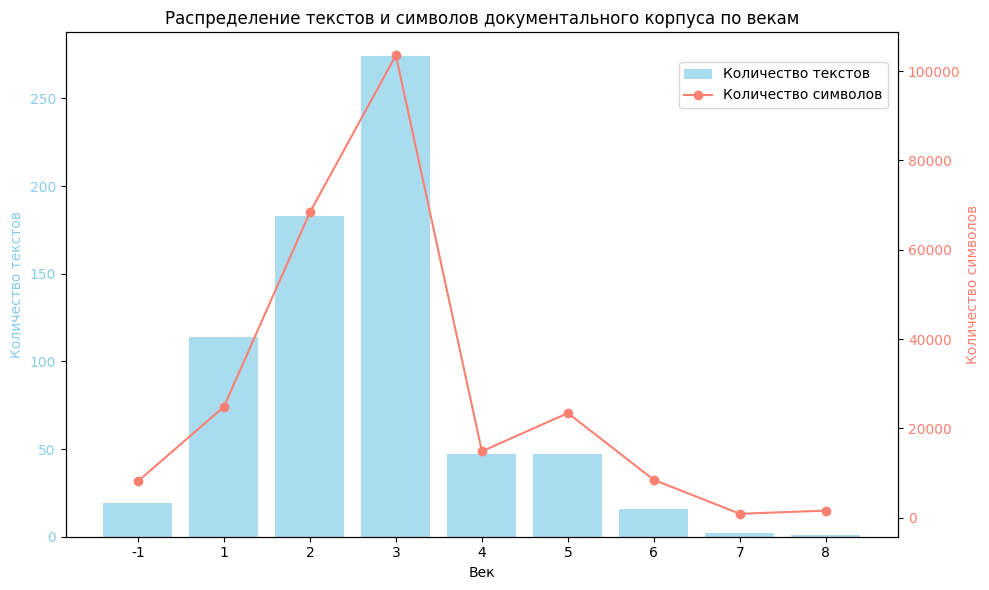

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

text_counts = cleaned_papyri['century'].value_counts().sort_index(ascending=True)
char_counts = cleaned_papyri.groupby('century')['num_chars'].sum().reset_index()

centuries = text_counts.index.astype(str)

ax1.bar(centuries, text_counts.values, color='skyblue', alpha=0.7, label='Количество текстов')
ax1.set_xlabel('Век')
ax1.set_ylabel('Количество текстов', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
ax2.plot(centuries, char_counts['num_chars'], color='salmon', marker='o', label='Количество символов')
ax2.set_ylabel('Количество символов', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

plt.title('Распределение текстов и символов документального корпуса по векам')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
output_path = '/content/drive/MyDrive/DIPLOMA/CORPORA/cleaned_papyri.csv'
cleaned_papyri.to_csv(output_path, index=False, encoding='utf-8-sig')

In [ ]:
output_path = '/content/drive/MyDrive/DIPLOMA/CORPORA/cleaned_ise.csv'
cleaned_ise.to_csv(output_path, index=False, encoding='utf-8-sig')

In [7]:
cleaned_papyri = pd.read_csv('/content/drive/MyDrive/DIPLOMA/CORPORA/cleaned_papyri.csv')
cleaned_ise = pd.read_csv('/content/drive/MyDrive/DIPLOMA/CORPORA/cleaned_ise.csv')

In [8]:
len(cleaned_ise)

879

In [9]:
len(cleaned_papyri)

703

**3.2. Выделение корпуса наиболее точно датированных текстов (интервалы < 50 лет)**

In [8]:
def determine_distance(df):
  distance = (df['upper_date'] - df['lower_date']).abs()
  large_distance_df = df[distance > 50].copy().reset_index(drop=True)
  new_df = df[distance <= 50].copy().reset_index(drop=True)

  return new_df, large_distance_df


In [9]:
sdist_papyri, ldist_papyri = determine_distance(cleaned_papyri)

In [9]:
len(sdist_papyri)

282

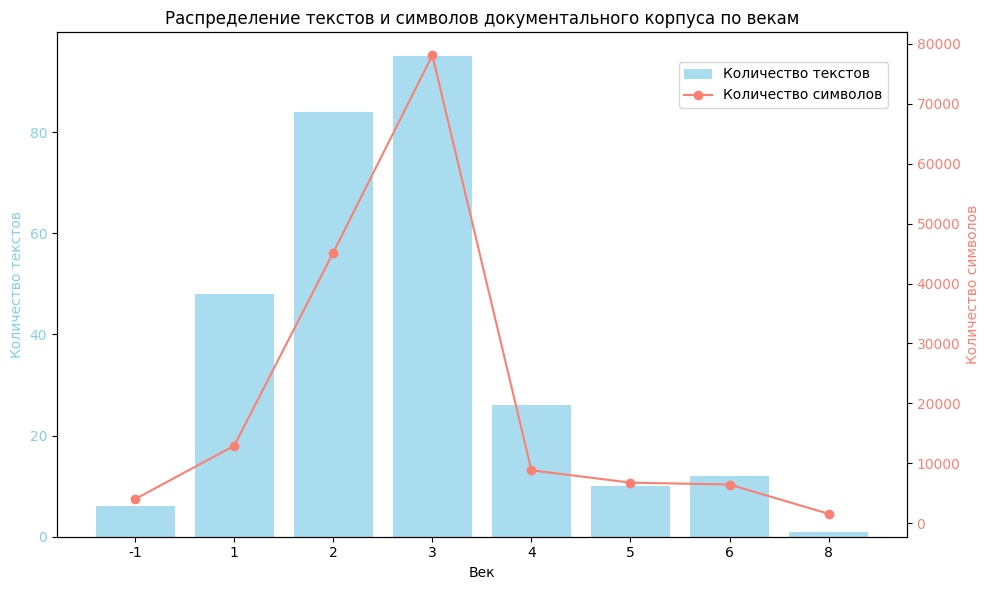

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

text_counts = sdist_papyri['century'].value_counts().sort_index(ascending=True)
char_counts = sdist_papyri.groupby('century')['num_chars'].sum().reset_index()

centuries = text_counts.index.astype(str)

ax1.bar(centuries, text_counts.values, color='skyblue', alpha=0.7, label='Количество текстов')
ax1.set_xlabel('Век')
ax1.set_ylabel('Количество текстов', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
ax2.plot(centuries, char_counts['num_chars'], color='salmon', marker='o', label='Количество символов')
ax2.set_ylabel('Количество символов', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

plt.title('Распределение текстов и символов документального корпуса по векам')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
sdist_ise, ldist_ise = determine_distance(cleaned_ise)

In [11]:
len(sdist_ise)

339

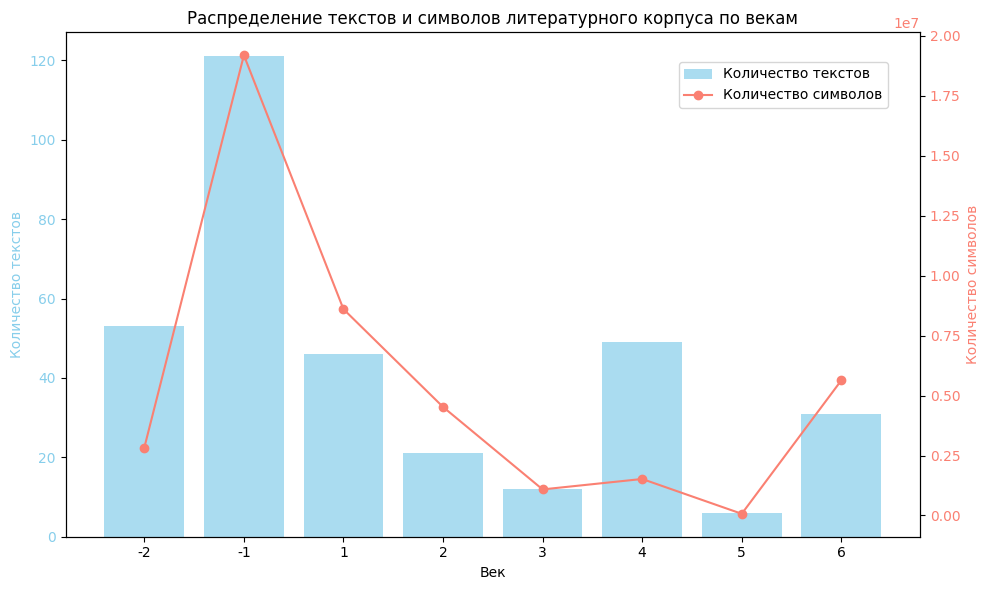

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

text_counts = sdist_ise['century'].value_counts().sort_index(ascending=True)
char_counts = sdist_ise.groupby('century')['num_chars'].sum().reset_index()

centuries = text_counts.index.astype(str)

ax1.bar(centuries, text_counts.values, color='skyblue', alpha=0.7, label='Количество текстов')
ax1.set_xlabel('Век')
ax1.set_ylabel('Количество текстов', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
ax2.plot(centuries, char_counts['num_chars'], color='salmon', marker='o', label='Количество символов')
ax2.set_ylabel('Количество символов', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

plt.title('Распределение текстов и символов литературного корпуса по векам')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**4. ОБУЧЕНИЕ МОДЕЛЕЙ**

**4.1. Нормализация текста**

In [12]:
# Очищаем текст от пробелов и всех символов, кроме буквенных и "_"
def clean_text(text):
    # Приводим к нижнему регистру
    text = text.lower()
    # Удаляем все символы, кроме букв и '_', а также пробелы
    text = re.sub(r'[^a-z_ ]', '', text)
    #text = text.replace('_', ' ')
    return text

In [13]:
# Создаем копию литературных текстов с сохраненными пробелами
spaced_ise = sdist_ise.copy()
spaced_ise['text'] = spaced_ise['text'].apply(clean_text)

In [14]:
spaced_ise

text    id        n  \
0    obsculta o fili praecepta magistri et inclina ...    IT  LAT0011   
1    magnus es domine et laudabilis valde magna vir...    IT  LAT0015   
2    praefatioante omnia fratres carissimi diligatu...    IT  LAT0016   
3    omnes homines qui sese student praestare ceter...    IT  LAT0029   
4    metamorphoses liber primus at ego tibi sermone...    IT  LAT0043   
..                                                 ...   ...      ...   
334  iactet se fortuna aliis quos iudice nullo ad r...  MQDQ      480   
335  cum primis quos non onerauit gloria patrum pro...  MQDQ      478   
336  uirtutem uerine tuam plus mirer in armis dux a...  MQDQ      481   
337  quis mihi maesta dabit lacrimosis imbribus ora...  MQDQ      537   
338  in nomine domini nostri iesu christi caesar fl...    IT  LAT0202   

                                                author         date  century  \
0                                 Benedictus Nursianus  522-526A.D.        6   
1                                 Augustinus, Aurelius  397-401A.D.        4   
2                                 Augustinus, Aurelius     391(TPQ)        4   
3                            Sallustius Crispus, Caius   43-34 B.C.       -1   
4                                     Apuleius, Lucius       158ca.        2   
..                                                 ...          ...      ...   
334                                    Symmachus pater   Ü376 A. D.        4   
335                                    Symmachus pater   Ü376 A. D.        4   
336                                    Symmachus pater   Ü376 A. D.        4   
337                     Verecundus Iuncensis Episcopus   Ü552 A. D.        6   
338  Iustinianus, Caesar Flavius (Imperator Iustini...    533 A. D.        6   

                             title   genre  \
0              S. Benedicti Regula   prose   
1                     Confessiones   prose   
2                           Regula   prose   
3          Omnia quae extant opera   prose   
4                    Metamorphoses   prose   
..                             ...     ...   
334            Petronius Probianus  poetry   
335              Valerius Proculus  poetry   
336                        Verinus  poetry   
337  de satisfactione paenitentiae  poetry   
338                  Institutiones   prose   

                                                   url  lower_date  mid_date  \
0    IntraText Digital Library http://www.intratext...         522       524   
1    IntraText Digital Library http://www.intratext...         397       399   
2    IntraText Digital Library http://www.intratext...         391       391   
3                http://www.intratext.com/IXT/LAT0029/         -43       -39   
4    IntraText Digital Library http://www.intratext...         158       158   
..                                                 ...         ...       ...   
334                                                NaN         376       376   
335                                                NaN         376       376   
336                                                NaN         376       376   
337           https://www.mqdq.it/texts/VEREC|sati|001         552       552   
338  IntraText Digital Library http://www.intratext...         533       533   

     upper_date  num_chars  
0           526     112858  
1           401      60649  
2           391      27012  
3           -34     444768  
4           158     669324  
..          ...        ...  
334         376        470  
335         376        483  
336         376        502  
337         552      16917  
338         533     983497  

[339 rows x 13 columns]

In [14]:
len(spaced_ise)

339

In [15]:
# Попытка балансировки кропуса через уменьшение представленности тектсов 1 в. до н.э.
spaced_ise = spaced_ise.sort_values(by='num_chars', ascending=False)
spaced_ise = spaced_ise.groupby('century').head(60).reset_index(drop=True)

len(spaced_ise)

278

In [16]:
spaced_ise = spaced_ise[~(spaced_ise['num_chars'] < 100)]

In [17]:
len(spaced_ise)

277

____________________________________________________________

In [18]:
sdist_papyri['text'] = sdist_papyri['text'].apply(clean_text)
sdist_papyri

filename                                               text  \
0            62952.xml  ci_a_maianarmavirumquecano troiae qui primus a...   
1    o.claud_2_304.xml  viii kser uieliocoraepi eaniitaelsilvaqser ori...   
2    o.claud_2_305.xml  oriiulisercorammonkalendasscopeliulianubierasa...   
3    o.claud_2_306.xml  iuliisidor_poserenvilikalendasiuliserencoriamm...   
4    o.claud_4_843.xml          hieronymincochlaxnmaiornminorarpochratenn   
..                 ...                                                ...   
277  o.bu.njem__82.xml  octavio festo_salutem_all_fil_milite_ellis_rel...   
278  o.bu.njem__83.xml  octaviofestodecurionipraepositomeoa_salutemisc...   
279  o.bu.njem__84.xml  octabiofesto decurionipropositomeo octavis aem...   
280  o.bu.njem__85.xml  octabiofesto decurioni praeposito meoacceptaii...   
281  o.bu.njem__89.xml  emeritus etpoppidiustoppidiusu_o salutem scias...   

              date                                           location  \
0        100 - 120  Fundort: Claudianus Mons (Eastern desert, Egyp...   
1       ca. AD 150                                    Mons Claudianus   
2       ca. AD 150                                    Mons Claudianus   
3       ca. AD 150                                    Mons Claudianus   
4    ca. 138 - 161                                                NaN   
..             ...                                                ...   
277         AD 259                                              Golas   
278     ca. AD 259                                              Golas   
279     ca. AD 259                                              Golas   
280         AD 259                                              Golas   
281         AD 259                                              Golas   

    material  lower_date  mid_date  upper_date  century  num_chars  
0    pottery         100       110         120        2        136  
1        NaN         150       150         150        2       1392  
2        NaN         150       150         150        2         67  
3        NaN         150       150         150        2         71  
4        NaN         138       149         161        2         41  
..       ...         ...       ...         ...      ...        ...  
277      NaN         259       259         259        3         76  
278      NaN         259       259         259        3        111  
279      NaN         259       259         259        3         84  
280      NaN         259       259         259        3        129  
281      NaN         259       259         259        3        185  

[282 rows x 10 columns]

In [19]:
# Удаляем слишком короткие тексты
sdist_papyri = sdist_papyri[~(sdist_papyri['num_chars'] < 10)]

In [80]:
len(sdist_papyri)

259

____________________________________________________________

In [ ]:
final_ise = spaced_ise.copy()
output_path = '/content/drive/MyDrive/DIPLOMA/CORPORA/final_ise.csv'
final_ise.to_csv(output_path, index=False, encoding='utf-8-sig')

In [ ]:
final_papyri = sdist_papyri.copy()
output_path = '/content/drive/MyDrive/DIPLOMA/CORPORA/final_papyri.csv'
final_papyri.to_csv(output_path, index=False, encoding='utf-8-sig')

In [10]:
final_ise = pd.read_csv('/content/drive/MyDrive/DIPLOMA/CORPORA/final_ise.csv')
final_papyri = pd.read_csv('/content/drive/MyDrive/DIPLOMA/CORPORA/final_papyri.csv')

In [ ]:
final_ise['text'].unique()

**4.2. Обучение моделей неглубокого обучения (SVR, GP, GBoosting, RandomForest, xTrees) с грид-сёрчем**

In [21]:
# Функция для вычисления MAE, P50 и P90 абсолютных ошибок
def calculate_percentile_errors(y_true, y_pred):
    errors = np.abs(y_true - y_pred)
    return {
        'mae': np.mean(errors),
        'p50': np.percentile(errors, 50),
        'p90': np.percentile(errors, 90),
        'p100': np.percentile(errors, 100),
        'r2': r2_score(y_true, y_pred)
    }

In [ ]:
# Функция для кросс-валидации (n_cv_iter=5 итераций) с подбором параметров
# Векторизация текста - tf_idf(ngram_range=(a, b))
def cross_validate(model, param_grid, texts, y, n_iter_search=20, n_cv_iter=5, cv=3, random_state=42):

    cv_results = []


    for i in range(n_cv_iter):
        # Разбиение данных
        X_train, X_test, y_train, y_test = train_test_split(
            texts, y, test_size=0.2,
            random_state=random_state+i
        )

        # Пайплайн с векторизацией
        pipeline = make_pipeline(
            TfidfVectorizer(ngram_range=(1, 3), max_features=3000, max_df=0.9),
            clone(model)
        )

        # Для Gaussian Process добавляем преобразование в dense
        if isinstance(model, GaussianProcessRegressor):
            pipeline.steps.append(('to_dense', lambda x: x.toarray()))

        # Поиск параметров
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions={
                f'{pipeline.steps[-1][0]}__{k}': v
                for k, v in param_grid.items()
            },
            n_iter=n_iter_search,
            cv=cv,
            scoring='neg_mean_absolute_error',
            random_state=random_state+i,
            n_jobs=-1
        )

        search.fit(X_train, y_train)

        # Оценка на тестовом наборе
        y_pred = search.predict(X_test)
        errors = calculate_percentile_errors(y_test, y_pred)

        cv_results.append({
            'iteration': i+1,
            'best_params': search.best_params_,
            'best_cv_score': -search.best_score_,
            'test_metrics': errors,
            'model': search.best_estimator_
        })

    # Возвращаем лучший результат по MAE
    best_result = min(cv_results, key=lambda x: x['test_metrics']['mae'])
    results_df = pd.DataFrame(cv_results)

    return results_df, best_result, y_test, y_pred

*4.2.1. Грид-серч на документальном корпусе*


In [ ]:
texts = final_papyri['text']
dates = final_papyri['mid_date']

In [ ]:
def get_evaluation(best_model):
  df = pd.DataFrame.from_dict(best_model['test_metrics'], orient='index', columns=['Value'])
  return df

In [ ]:
# Обучаем SVR
svr = SVR()
param_grid = {
    'kernel': ['rbf'],
    'C': np.logspace(-2, 2, 5),  # [0.01, 0.1, 1, 10, 100]
    'epsilon': np.linspace(0.01, 0.2, 5),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5))
}

svr_all, svr_best, svr_true, svr_pred = cross_validate(svr, param_grid, texts, dates)
svr_best

{'iteration': 2,
 'best_params': {'svr__kernel': 'rbf',
  'svr__gamma': np.float64(1.0),
  'svr__epsilon': np.float64(0.15250000000000002),
  'svr__C': np.float64(100.0)},
 'best_cv_score': np.float64(102.40388502921031),
 'test_metrics': {'mae': np.float64(83.73238408292997),
  'p50': np.float64(60.0),
  'p90': np.float64(168.12213702501893),
  'p100': np.float64(375.8473287187263)},
 'model': Pipeline(steps=[('tfidfvectorizer',
                  TfidfVectorizer(max_df=0.9, max_features=3000,
                                  ngram_range=(1, 3))),
                 ('svr',
                  SVR(C=np.float64(100.0),
                      epsilon=np.float64(0.15250000000000002),
                      gamma=np.float64(1.0)))])}

In [ ]:
get_evaluation(svr_best)

Value
mae    82.692807
p50    74.212433
p90   185.212433
p100  300.212433

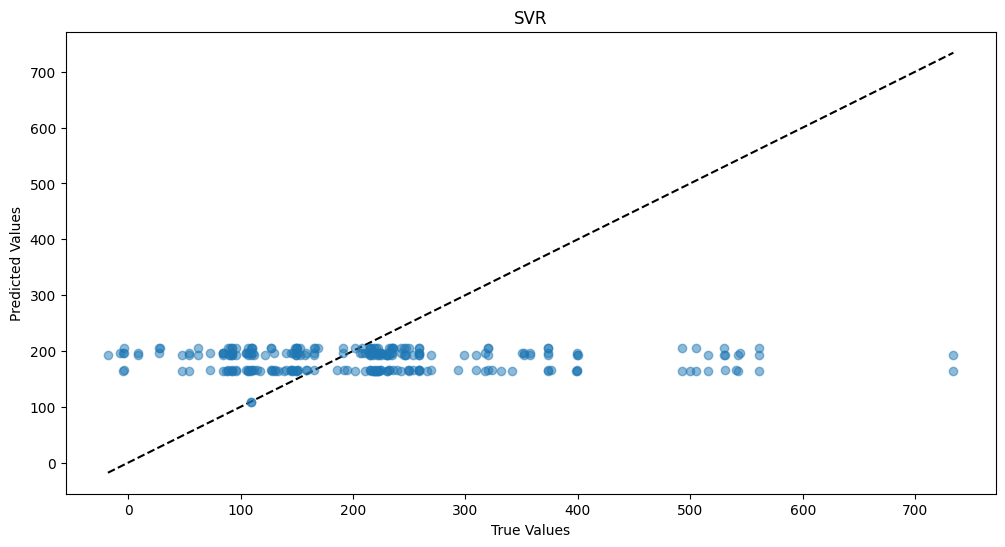

In [ ]:
plt.figure(figsize=(12, 6))
plt.errorbar(svr_true, svr_pred, fmt='o', alpha=0.5)
plt.plot([min(svr_true), max(svr_true)], [min(svr_true), max(svr_true)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('SVR')
plt.show()

In [ ]:
# Обучаем GP (без автоматической кросс-валидации)
kernel = ConstantKernel(0.5) * RBF(length_scale=0.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)

X_train, X_test, y_train, y_test = train_test_split(
            texts, dates,
            test_size=0.2,
            random_state=42
        )

tf_idf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_train_vec = tf_idf.fit_transform(X_train)
X_test_vec = tf_idf.transform(X_test)

gp.fit(X_train_vec.toarray(), y_train)
gp_pred, gp_std = gp.predict(X_test_vec.toarray(), return_std=True)

errors = calculate_percentile_errors(y_test, gp_pred)
pd.DataFrame.from_dict(errors, orient='index', columns=['Value'])

Value
mae   108.722180
p50   103.000000
p90   227.377365
p100  286.922635

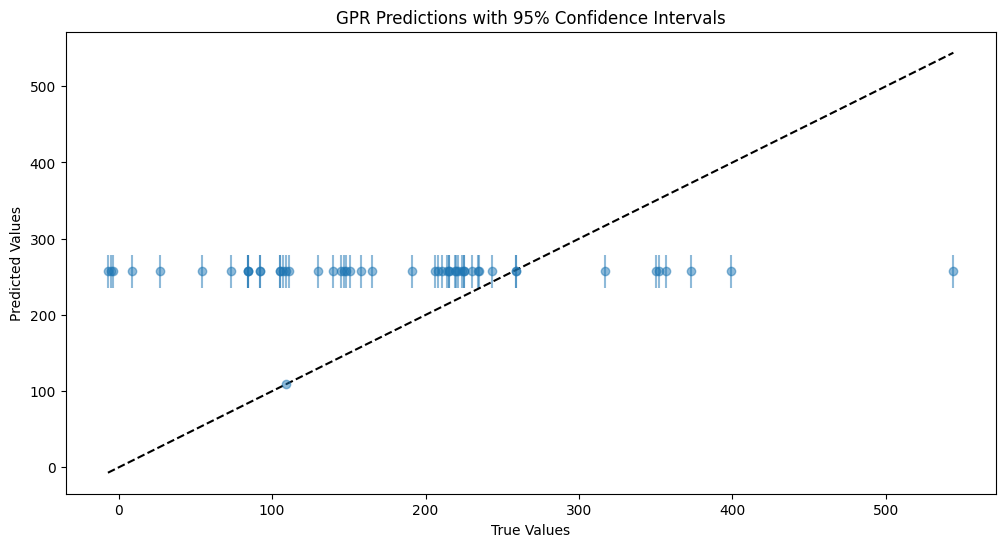

In [ ]:
plt.figure(figsize=(12, 6))
plt.errorbar(y_test, gp_pred, yerr=1.96*gp_std, fmt='o', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('GPR Predictions with 95% Confidence Intervals')
plt.show()

In [ ]:
# Обучаем GBoosting
gb = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gb_all, gb_best, gb_true, gb_pred = cross_validate(gb, param_grid, texts, dates)
gb_best

{'iteration': 2,
 'best_params': {'gradientboostingregressor__n_estimators': 50,
  'gradientboostingregressor__min_samples_split': 2,
  'gradientboostingregressor__max_depth': 3,
  'gradientboostingregressor__learning_rate': 0.01},
 'best_cv_score': np.float64(103.56318816030874),
 'test_metrics': {'mae': np.float64(80.75),
  'p50': np.float64(63.70272736380474),
  'p90': np.float64(160.63781810895617),
  'p100': np.float64(331.29727263619526)},
 'model': Pipeline(steps=[('tfidfvectorizer',
                  TfidfVectorizer(max_df=0.9, max_features=3000,
                                  ngram_range=(1, 3))),
                 ('gradientboostingregressor',
                  GradientBoostingRegressor(learning_rate=0.01,
                                            n_estimators=50))])}

In [ ]:
get_evaluation(gb_best)

Value
mae    88.493262
p50    68.668301
p90   185.870505
p100  344.331699

In [ ]:
# Обучаем RandomForest
rf = RandomForestRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_all, rf_best, rf_true, rf_pred = cross_validate(rf, param_grid, texts, dates)
rf_best

{'iteration': 2,
 'best_params': {'randomforestregressor__n_estimators': 50,
  'randomforestregressor__min_samples_split': 5,
  'randomforestregressor__max_features': 'sqrt',
  'randomforestregressor__max_depth': None},
 'best_cv_score': np.float64(102.48632988267771),
 'test_metrics': {'mae': np.float64(80.94507570207571),
  'p50': np.float64(62.5),
  'p90': np.float64(177.13598412698406),
  'p100': np.float64(350.0359841269841)},
 'model': Pipeline(steps=[('tfidfvectorizer',
                  TfidfVectorizer(max_df=0.9, max_features=3000,
                                  ngram_range=(1, 3))),
                 ('randomforestregressor',
                  RandomForestRegressor(max_features='sqrt', min_samples_split=5,
                                        n_estimators=50))])}

In [ ]:
get_evaluation(rf_best)

Value
mae    88.901011
p50    60.472057
p90   185.848708
p100  331.472057

In [ ]:
# Обучаем xTrees
xt = ExtraTreesRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

xt_all, xt_best, xt_true, xt_pred = cross_validate(xt, param_grid, texts, dates)
xt_best

{'iteration': 2,
 'best_params': {'extratreesregressor__n_estimators': 100,
  'extratreesregressor__min_samples_split': 5,
  'extratreesregressor__max_features': 'log2',
  'extratreesregressor__max_depth': None},
 'best_cv_score': np.float64(102.65729468599034),
 'test_metrics': {'mae': np.float64(80.84875000000001),
  'p50': np.float64(62.932500000000005),
  'p90': np.float64(175.66749999999993),
  'p100': np.float64(348.5675)},
 'model': Pipeline(steps=[('tfidfvectorizer',
                  TfidfVectorizer(max_df=0.9, max_features=3000,
                                  ngram_range=(1, 3))),
                 ('extratreesregressor',
                  ExtraTreesRegressor(max_features='log2',
                                      min_samples_split=5))])}

In [ ]:
xt_all

iteration                                        best_params  \
0          1  {'extratreesregressor__n_estimators': 50, 'ext...   
1          2  {'extratreesregressor__n_estimators': 50, 'ext...   
2          3  {'extratreesregressor__n_estimators': 50, 'ext...   
3          4  {'extratreesregressor__n_estimators': 50, 'ext...   
4          5  {'extratreesregressor__n_estimators': 100, 'ex...   

   best_cv_score                                       test_metrics  \
0      92.777425  {'mae': 98.13538543328016, 'p50': 92.599545454...   
1      87.434214  {'mae': 116.82963287849253, 'p50': 95.03703703...   
2      94.678685  {'mae': 93.5988925920001, 'p50': 62.1863829787...   
3      92.005986  {'mae': 88.86286825554453, 'p50': 60.894339622...   
4      90.127330  {'mae': 97.67064327485383, 'p50': 80.905660377...   

                                               model  
0  (TfidfVectorizer(max_df=0.9, max_features=3000...  
1  (TfidfVectorizer(max_df=0.9, max_features=3000...  
2  (TfidfVectorizer(max_df=0.9, max_features=3000...  
3  (TfidfVectorizer(max_df=0.9, max_features=3000...  
4  (TfidfVectorizer(max_df=0.9, max_features=3000...

*4.2.2. Грид-серч на литературном корпусе*

In [ ]:
# Функции для грид-серча моделей на литературном корпусе
#  + Ручная аугментация латинских текстов
def augment_text(text, n_augments=2):
    augmented = [text]
    words = text.split()

    for _ in range(n_augments):
        if len(words) > 1:
            shuffled = words.copy()
            random.shuffle(shuffled)
            new_text = ' '.join(shuffled)
            if new_text != text:
                augmented.append(new_text)

    return list(set(augmented))

def train_model_with_augmentation(texts, dates, model, param_grid, augment, n_augments=2, cv=3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        texts, dates, test_size=0.2, random_state=random_state
    )


    if augment:
        augmented_texts = []
        augmented_dates = []

        for text, date in zip(X_train, y_train):
            augs = augment_text(text, n_augments=n_augments)
            augmented_texts.extend(augs)
            augmented_dates.extend([date] * len(augs))

        X_train_final = augmented_texts
        y_train_final = augmented_dates
    else:
        X_train_final = X_train
        y_train_final = y_train

    vectorizer = TfidfVectorizer(
        ngram_range=(1, 5),
        max_features=10000,
        analyzer='char_wb',
        sublinear_tf=True
    )

    X_train_vec = vectorizer.fit_transform(X_train_final)
    X_test_vec = vectorizer.transform(X_test)

    search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        verbose=1
    )

    search.fit(X_train_vec, y_train_final)
    best_model = search.best_estimator_

    y_pred = best_model.predict(X_test_vec)
    errors = calculate_percentile_errors(y_test, y_pred)


    result = {
        'best_model': best_model,
        'test_metrics': errors,
        'best_params': search.best_params_,
        'augment': augment,
    }

    return result, y_test, y_pred

In [22]:
# Функция для визуализации работы модели по векам
def century_from_year(year):
    if year > 0:
        return (year - 1) // 100 + 1
    else:
        return -((-year - 1) // 100 + 1)


def plot_century_heatmap(y_true, y_pred):

    true_centuries = [century_from_year(y) for y in y_true]
    pred_centuries = [century_from_year(y) for y in y_pred]

    # Создаём список всех веков в данных (учитывая отсутствие 0 века)
    all_centuries = sorted(set(true_centuries + pred_centuries))
    if 0 in all_centuries:
        all_centuries.remove(0)  # Удаляем 0 век, если он случайно появился

    # Создаём матрицу путаницы
    cm = np.zeros((len(all_centuries), len(all_centuries)), dtype=int)

    # Заполняем матрицу
    for true, pred in zip(true_centuries, pred_centuries):
        if true in all_centuries and pred in all_centuries:
            i = all_centuries.index(true)
            j = all_centuries.index(pred)
            cm[i, j] += 1

    # Подписи для оси (BC/AD)
    labels = [f"{c} BC" if c < 0 else f"{c} AD" for c in all_centuries]

    # Рисуем тепловую карту
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Количество предсказаний'})

    plt.title('Распределение предсказаний по векам', fontsize=14)
    plt.xlabel('Предсказанный век', fontsize=12)
    plt.ylabel('Истинный век', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
texts = final_ise['text']
dates = final_ise['mid_date']

In [ ]:
# Обучаем SVR
svr = SVR()
param_grid = {
    'kernel': [ 'rbf'],
    'C': [0.1, 1, 100],
    'epsilon': [ 0.1, 0.5, 1],
}

svr_results, svr_true, svr_pred = train_model_with_augmentation(texts, dates, svr, param_grid, augment=True)
svr_results

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'best_model': SVR(C=100),
 'test_metrics': {'mae': np.float64(105.67263854990097),
  'p50': np.float64(61.03041193588945),
  'p90': np.float64(281.4068820280575),
  'p100': np.float64(380.0555964648969)},
 'best_params': {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'},
 'augment': True}

In [ ]:
get_evaluation(svr_results)

Value
mae   105.672639
p50    61.030412
p90   281.406882
p100  380.055596

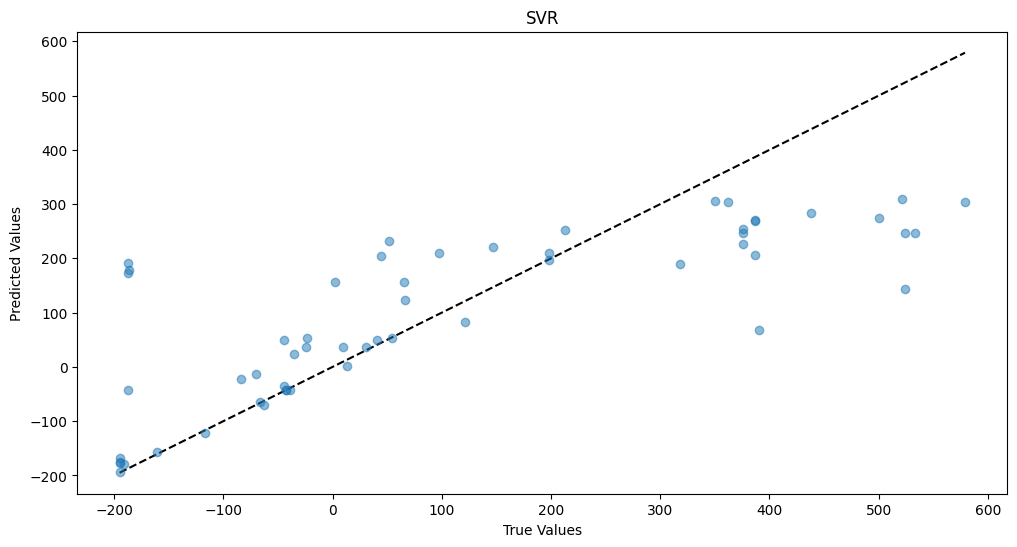

In [ ]:
plt.figure(figsize=(12, 6))
plt.errorbar(svr_true, svr_pred, fmt='o', alpha=0.5)
plt.plot([min(svr_true), max(svr_true)], [min(svr_true), max(svr_true)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('SVR')
plt.show()

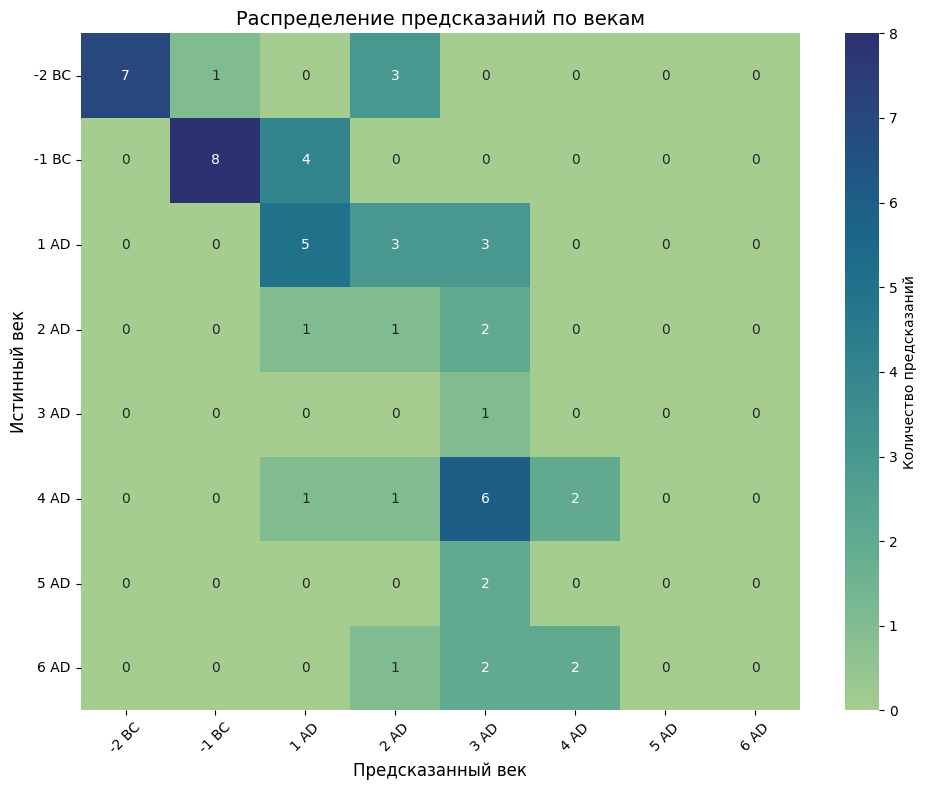

In [ ]:
plot_century_heatmap(svr_true, svr_pred)

In [ ]:
# Обучаем GP (без автоматической кросс-валидации)
kernel = ConstantKernel(0.5) * RBF(length_scale=0.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)

X_train, X_test, y_train, y_test = train_test_split(
            texts, dates,
            test_size=0.2,
            random_state=42
        )

tf_idf = TfidfVectorizer(ngram_range=(1, 5), max_features=10000)
X_train_vec = tf_idf.fit_transform(X_train)
X_test_vec = tf_idf.transform(X_test)

gp.fit(X_train_vec.toarray(), y_train)
gp_pred, gp_std = gp.predict(X_test_vec.toarray(), return_std=True)

errors = calculate_percentile_errors(y_test, gp_pred)
pd.DataFrame.from_dict(errors, orient='index', columns=['Value'])

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Value
mae    93.910738
p50    48.799456
p90   262.612274
p100  349.575948
r2      0.681829

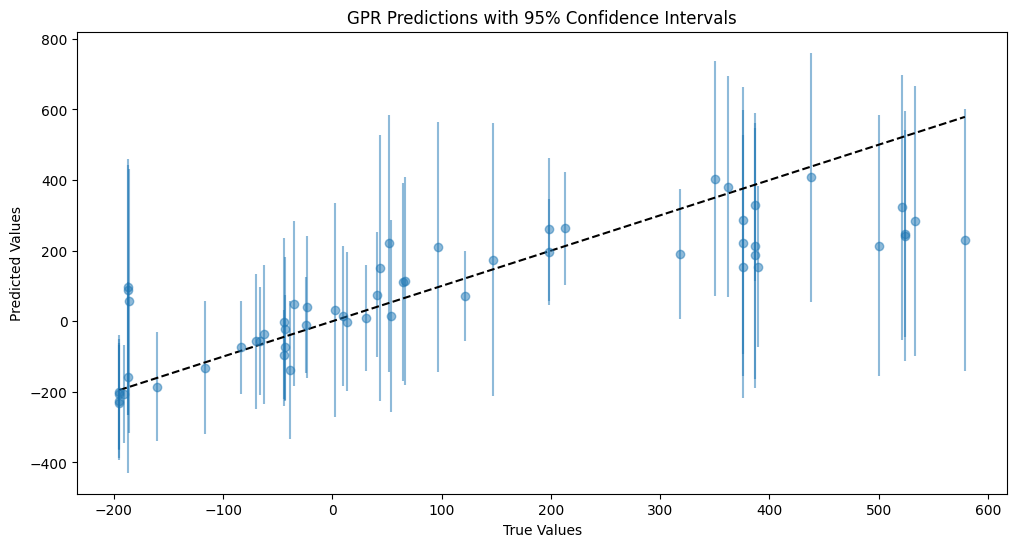

In [ ]:
plt.figure(figsize=(12, 6))
plt.errorbar(y_test, gp_pred, yerr=1.96*gp_std, fmt='o', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('GPR Predictions with 95% Confidence Intervals')
plt.show()

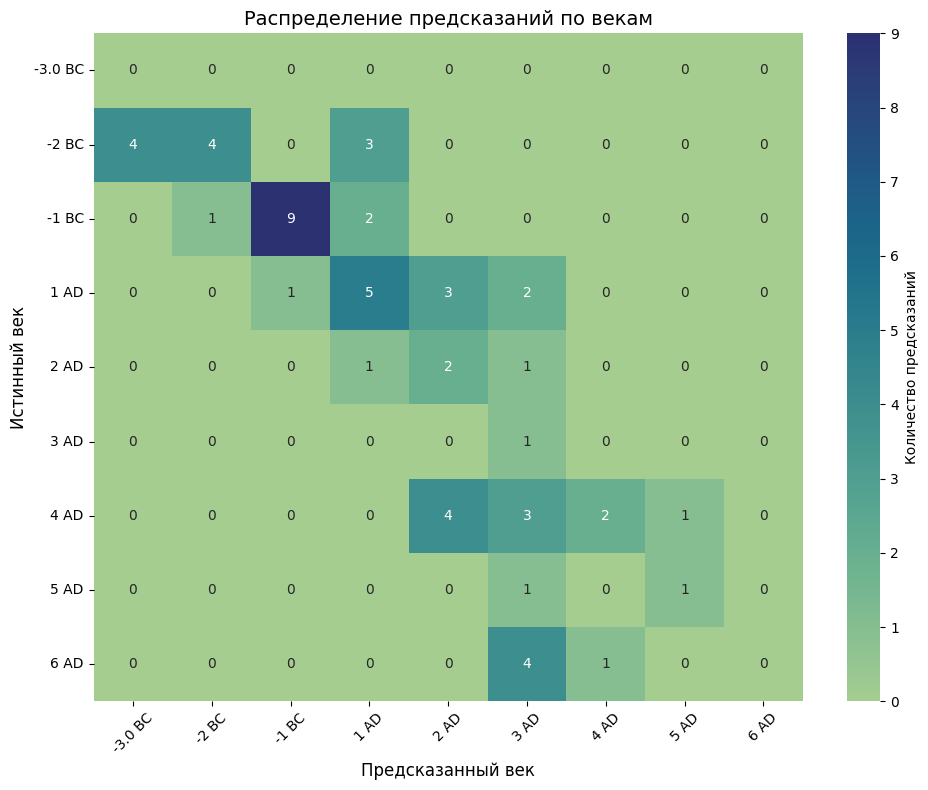

In [ ]:
plot_century_heatmap(y_test, gp_pred)

In [ ]:
# Обучаем xTrees
xt = ExtraTreesRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'max_features': ['sqrt', 'log2']
}

xt_result, xt_true, xt_pred = train_model_with_augmentation(texts, dates, xt, param_grid, augment=True)
xt_result

Fitting 3 folds for each of 24 candidates, totalling 72 fits


{'best_model': ExtraTreesRegressor(max_features='sqrt', min_samples_split=10),
 'test_metrics': {'mae': np.float64(117.5089880952381),
  'p50': np.float64(79.71916666666668),
  'p90': np.float64(278.13750000000005),
  'p100': np.float64(395.35166666666663)},
 'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_split': 10,
  'n_estimators': 100},
 'augment': True}

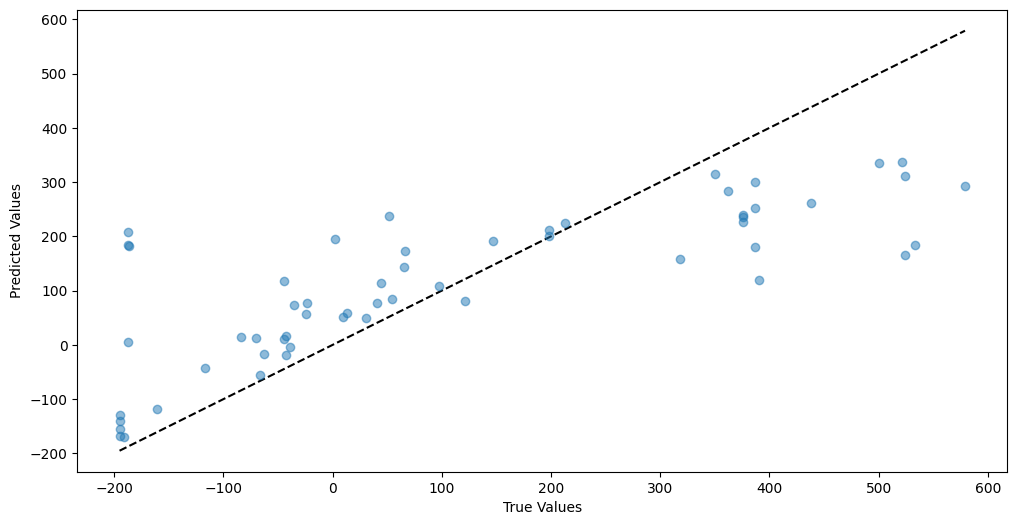

In [ ]:
plt.figure(figsize=(12, 6))
plt.errorbar(xt_true, xt_pred, fmt='o', alpha=0.5)
plt.plot([min(y_test), max(xt_true)], [min(xt_true), max(xt_true)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

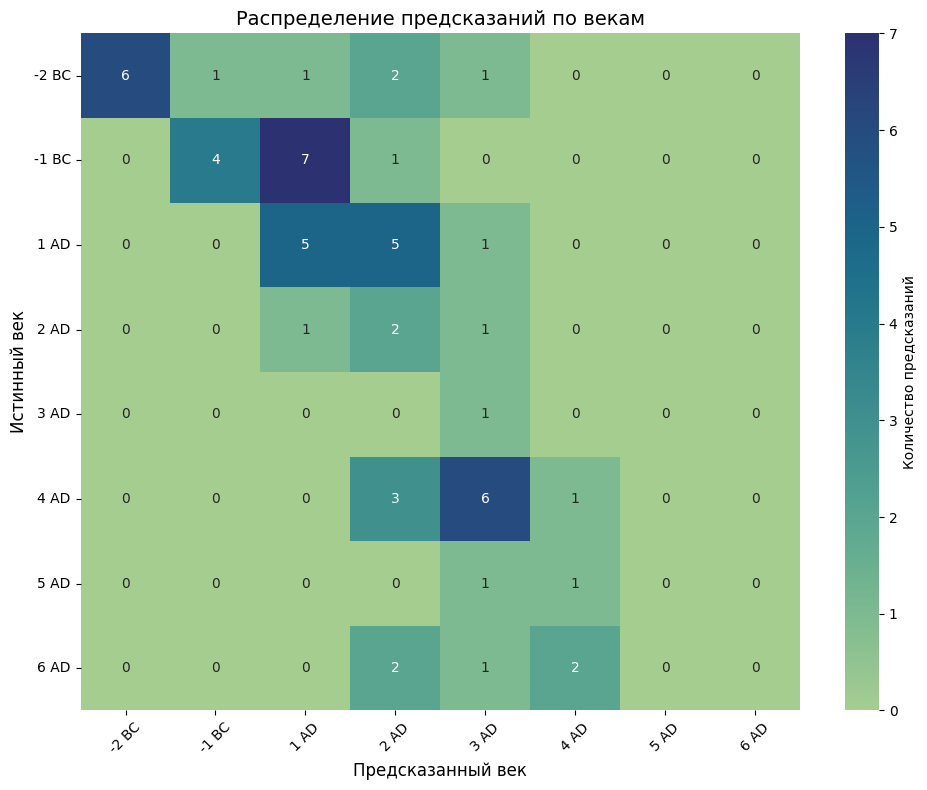

In [ ]:
plot_century_heatmap(xt_true, xt_pred)

In [ ]:
# Обучаем GBoosting
gb = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 7],
    'min_samples_split': [2, 10]
}

gb_results, gb_true, gb_pred = train_model_with_augmentation(texts, dates, gb, param_grid, augment=True)
gb_results

Fitting 3 folds for each of 24 candidates, totalling 72 fits


{'best_model': GradientBoostingRegressor(),
 'test_metrics': {'mae': np.float64(104.58211863352717),
  'p50': np.float64(67.01049461588465),
  'p90': np.float64(242.97504918232414),
  'p100': np.float64(505.79133428428383)},
 'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'min_samples_split': 2,
  'n_estimators': 100},
 'augment': True}

In [ ]:
plt.figure(figsize=(12, 6))
plt.errorbar(gb_true, gb_pred, fmt='o', alpha=0.5)
plt.plot([min(gb_true), max(gb_true)], [min(gb_true), max(gb_true)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('GPR Predictions with 95% Confidence Intervals')
plt.show()

NameError: name 'plt' is not defined

**4.3. Обучение и применение модели на коротком литературном корпусе (без 4-6 веков)**

In [ ]:
new_final_ise = final_ise.copy()
new_final_ise = new_final_ise[~(new_final_ise['century'] > 3)].reset_index(drop=True)
texts = new_final_ise['text']
dates = new_final_ise['mid_date']

In [ ]:
len(new_final_ise)

277

In [ ]:
len(new_final_ise.loc[new_final_ise['genre'] == 'poetry'])

150

In [ ]:
new_final_ise.loc[new_final_ise['genre'] == 'poetry'].groupby('century').count()

text  id   n  author  date  title  genre  url  lower_date  mid_date  \
century                                                                        
-2         50  50  50      50    50     50     50   50          50        50   
-1         14  14  14      14    14     14     14   14          14        14   
 1         27  27  27      27    27     27     27   19          27        27   
 2          2   2   2       2     2      2      2    0           2         2   
 4         30  30  30      30    30     30     30   21          30        30   
 5          3   3   3       3     3      3      3    2           3         3   
 6         24  24  24      24    24     24     24    5          24        24   

         upper_date  num_chars  
century                         
-2               50         50  
-1               14         14  
 1               27         27  
 2                2          2  
 4               30         30  
 5                3          3  
 6               24         24

In [177]:
new_final_ise.loc[new_final_ise['genre'] == 'prose'].groupby('century').count()

text  id   n  author  date  title  genre  url  lower_date  mid_date  \
century                                                                        
-2          3   3   3       3     3      3      3    3           3         3   
-1         46  46  46      46    46     46     46   46          46        46   
 1         18  18  18      18    18     18     18   18          18        18   
 2         19  19  19      19    19     19     19   19          19        19   
 3         12  12  12      12    12     12     12   12          12        12   

         upper_date  num_chars  
century                         
-2                3          3  
-1               46         46  
 1               18         18  
 2               19         19  
 3               12         12

In [23]:
# Алгоритмы с лучшими параметрами
svr_best = SVR(C=100, epsilon=0.1, kernel='rbf')

kernel_best = ConstantKernel(0.5) * RBF(length_scale=0.5)
gp_best = GaussianProcessRegressor(kernel=kernel_best, alpha=0.1)

gb_best = GradientBoostingRegressor(n_estimators=100, max_depth=3, min_samples_split=2, learning_rate=0.1)
xt_best = ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=10, max_features='sqrt')

In [136]:
# Функция для вычисления MAE, P50 и P90 абсолютных ошибок
def calculate_percentile_errors(y_true, y_pred):
    errors = np.abs(y_true - y_pred)
    return {
        'mae': np.mean(errors),
        'p50': np.percentile(errors, 50),
        'p90': np.percentile(errors, 90),
        'p100': np.percentile(errors, 100),
        'r2': r2_score(y_true, y_pred)
    }

In [25]:
# Функция аугментации
def augment_text(text, n_augments=2):
  augmented = [text]
  words = text.split()

  for _ in range(n_augments):
      if len(words) > 1:
          shuffled = words.copy()
          random.shuffle(shuffled)
          new_text = ' '.join(shuffled)
          if new_text != text:
              augmented.append(new_text)

  return list(set(augmented))

In [137]:
# Функция для визуализации работы модели по векам
def century_from_year(year):
    if year > 0:
        return (year - 1) // 100 + 1
    else:
        return -((-year - 1) // 100 + 1)


def plot_century_heatmap(y_true, y_pred):

    true_centuries = [century_from_year(y) for y in y_true]
    pred_centuries = [century_from_year(y) for y in y_pred]

    # Создаём список всех веков в данных (учитывая отсутствие 0 века)
    all_centuries = sorted(set(true_centuries + pred_centuries))
    if 0 in all_centuries:
        all_centuries.remove(0)  # Удаляем 0 век, если он случайно появился

    # Создаём матрицу путаницы
    cm = np.zeros((len(all_centuries), len(all_centuries)), dtype=int)

    # Заполняем матрицу
    for true, pred in zip(true_centuries, pred_centuries):
        if true in all_centuries and pred in all_centuries:
            i = all_centuries.index(true)
            j = all_centuries.index(pred)
            cm[i, j] += 1

    # Подписи для оси (BC/AD)
    labels = [f"{c} BC" if c < 0 else f"{c} AD" for c in all_centuries]

    # Рисуем тепловую карту
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Количество предсказаний'})

    plt.title('Распределение предсказаний по векам', fontsize=14)
    plt.xlabel('Предсказанный век', fontsize=12)
    plt.ylabel('Истинный век', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [138]:
# Функция для обучения модели (без аугментации - не хватает памяти)
def train_model(model, texts, dates):

    tf_idf = TfidfVectorizer(ngram_range=(1, 5), max_features=5000)

    # Разделение на выборки
    X_train, X_test, y_train, y_test = train_test_split(texts, dates, test_size=0.2, random_state=42)



    # Векторизация
    X_train_tfidf = tf_idf.fit_transform(X_train)
    X_test_tfidf = tf_idf.transform(X_test)

    # Видоизменение матрицы признаков ля GP
    is_gp = (hasattr(model, '__class__') and
             'GaussianProcess' in model.__class__.__name__)

    if is_gp:
      X_train_tfidf = X_train_tfidf.toarray()
      X_test_tfidf = X_test_tfidf.toarray()

    # Обучение и оценка модели
    model = deepcopy(model)
    model.fit(X_train_tfidf, y_train)

    y_pred = model.predict(X_test_tfidf)
    metrics = calculate_percentile_errors(y_test, y_pred)

    return {
          'model': model,
          'metrics': metrics,
            }, y_test, y_pred

In [ ]:
svr_result, svr_true, svr_pred = train_model(svr_best, texts, dates)


In [ ]:
pd.DataFrame.from_dict(svr_result['metrics'], orient='index', columns=['Value'])

Value
mae    41.686344
p50    17.960087
p90    95.611131
p100  240.413357
r2      0.735508

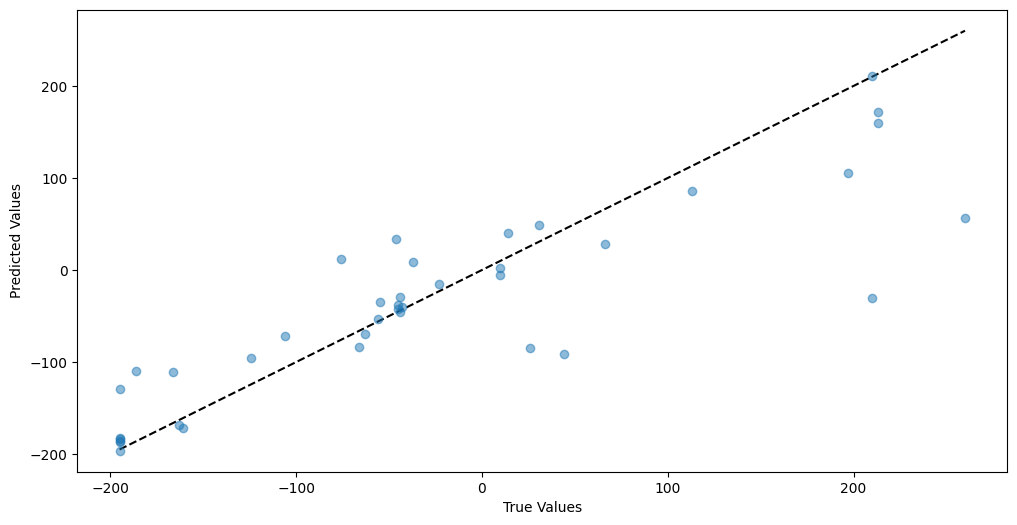

In [ ]:
plt.figure(figsize=(12, 6))
plt.errorbar(svr_true, svr_pred, fmt='o', alpha=0.5)
plt.plot([min(svr_true), max(svr_true)], [min(svr_true), max(svr_true)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

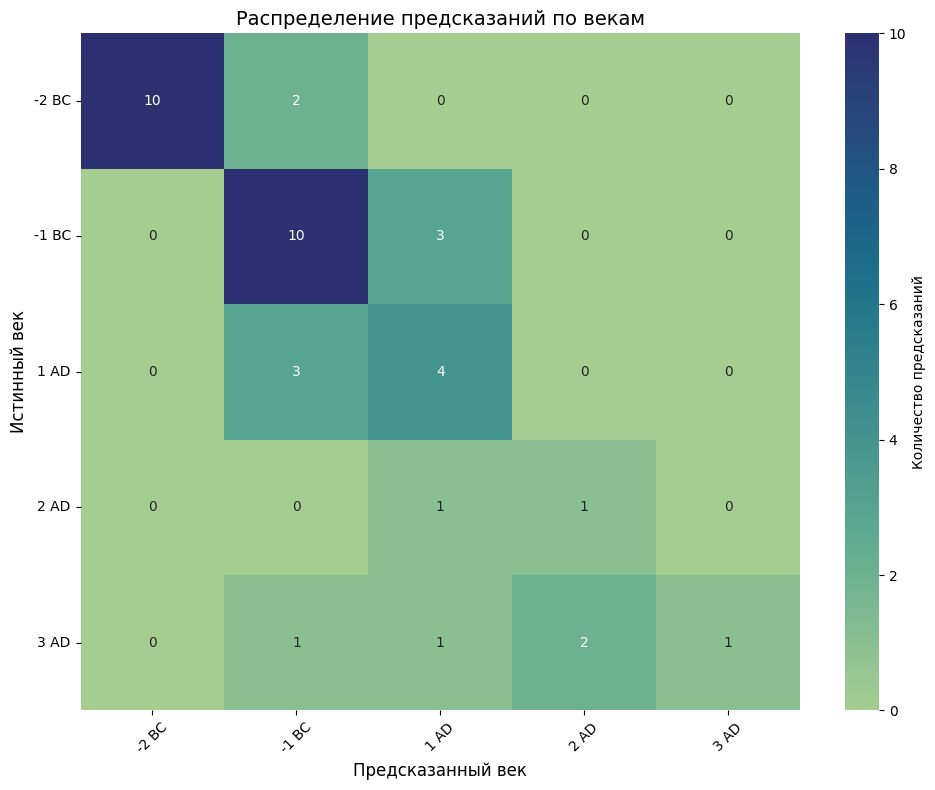

In [ ]:
plot_century_heatmap(svr_true, svr_pred)

In [ ]:
gp_result, gp_true, gp_pred = train_model(gp_best, texts, dates)

In [ ]:
pd.DataFrame.from_dict(gp_result['metrics'], orient='index', columns=['Value'])

Value
mae    36.503396
p50    17.888447
p90    88.476601
p100  177.088908
r2      0.812243

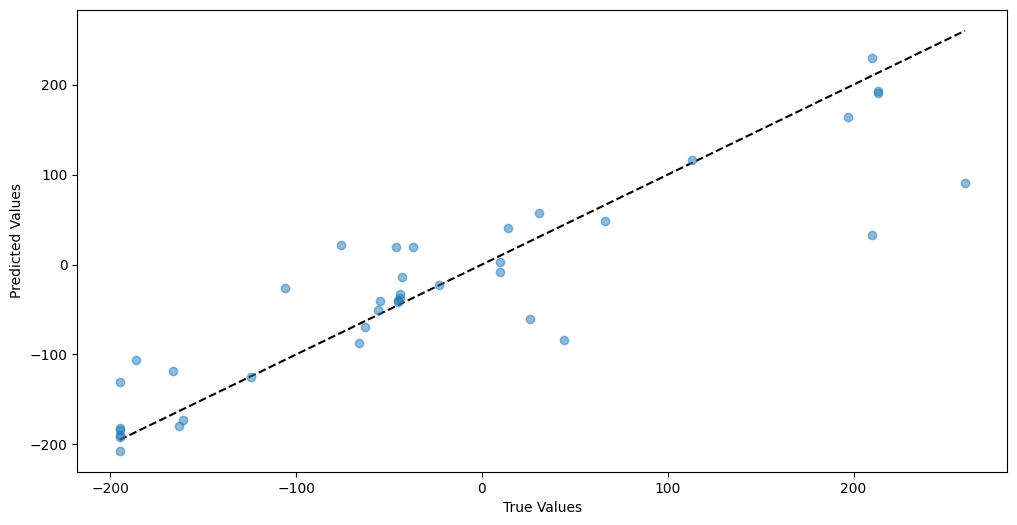

In [ ]:
plt.figure(figsize=(12, 6))
plt.errorbar(gp_true, gp_pred, fmt='o', alpha=0.5)
plt.plot([min(gp_true), max(gp_true)], [min(gp_true), max(gp_true)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

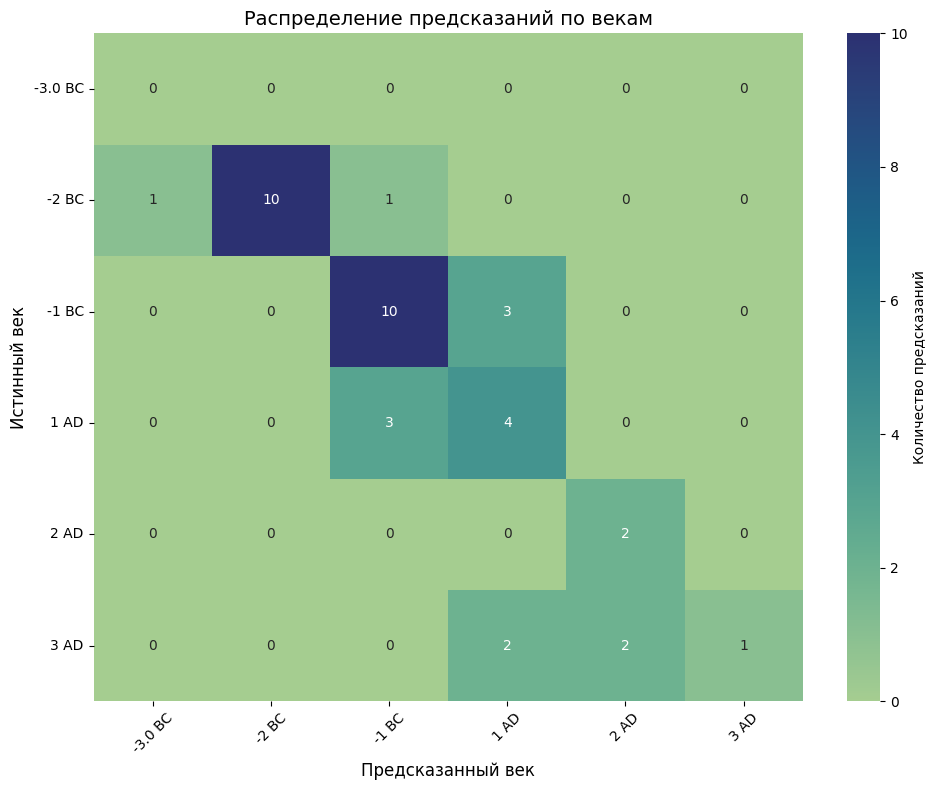

In [ ]:
plot_century_heatmap(gp_true, gp_pred)

In [ ]:
gb_result, gb_true, gb_pred = train_model(gb_best, texts, dates)

In [ ]:
pd.DataFrame.from_dict(gb_result['metrics'], orient='index', columns=['Value'])

Value
mae    37.798968
p50    16.909692
p90    84.293635
p100  241.334454
r2      0.772382

In [ ]:
xt_result, xt_true, xt_pred = train_model(xt_best, texts, dates)

In [ ]:
pd.DataFrame.from_dict(xt_result['metrics'], orient='index', columns=['Value'])

Value
mae    58.807341
p50    35.892754
p90   121.775171
p100  301.189226
r2      0.554903

In [ ]:
# Обучим стэкинг с учетом разницы представления признаков
to_dense = FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X)

gp_pipeline = make_pipeline(to_dense, gp_best)
estimators = [('svr', svr_best), ('boost', gb_best), ('gp', gp_pipeline)]

# Стекинг с конвертацией
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=xt_best
)

In [141]:
stack_result, stack_true, stack_pred = train_model(stack, texts, dates)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: C

In [142]:
pd.DataFrame.from_dict(stack_result['metrics'], orient='index', columns=['Value'])

Value
mae    46.822683
p50    25.872399
p90   111.207936
p100  375.471794
r2      0.832276

In [ ]:
pd.DataFrame.from_dict(stack_result['metrics'], orient='index', columns=['Value'])

Value
mae    32.192395
p50    10.998798
p90   102.265773
p100  188.364631
r2      0.817832

In [ ]:
# 2bc - 4ad
pd.DataFrame.from_dict(stack_result['metrics'], orient='index', columns=['Value'])

Value
mae    75.581833
p50    42.900113
p90   194.947269
p100  384.789167
r2      0.620875

In [ ]:
# 2bc - 5ad
pd.DataFrame.from_dict(stack_result['metrics'], orient='index', columns=['Value'])

Value
mae    86.309768
p50    51.755653
p90   182.189620
p100  432.309107
r2      0.654279

In [ ]:
# 2bc - 6ad
pd.DataFrame.from_dict(stack_result['metrics'], orient='index', columns=['Value'])

Value
mae    81.993445
p50    52.400397
p90   215.148361
p100  342.249651
r2      0.749452

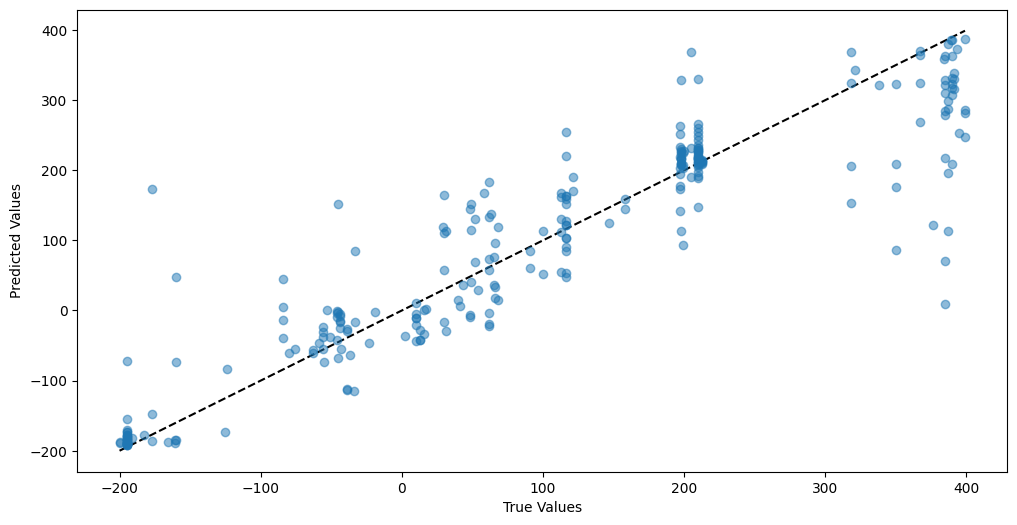

In [144]:
plt.figure(figsize=(12, 6))
plt.errorbar(stack_true, stack_pred, fmt='o', alpha=0.5)
plt.plot([min(stack_true), max(stack_true)], [min(stack_true), max(stack_true)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

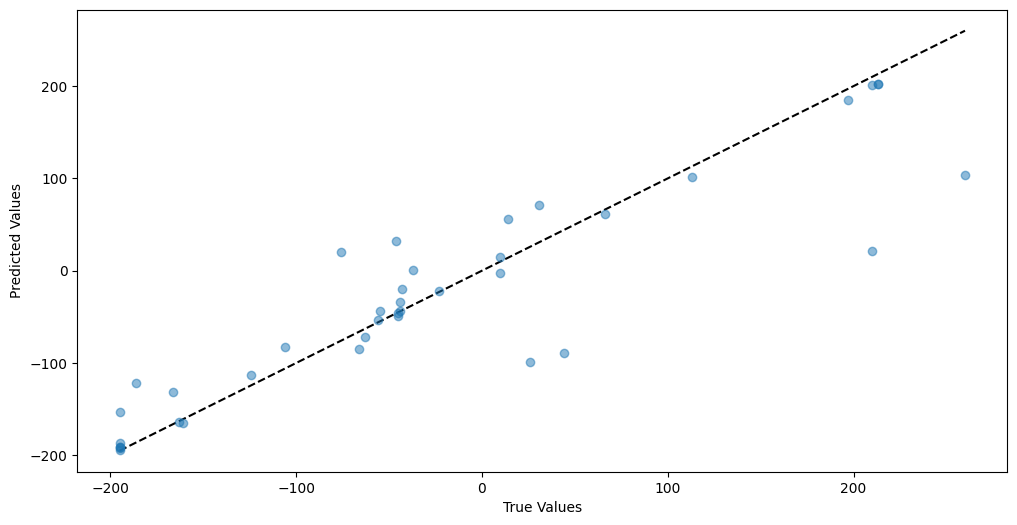

In [ ]:
plt.figure(figsize=(12, 6))
plt.errorbar(stack_true, stack_pred, fmt='o', alpha=0.5)
plt.plot([min(stack_true), max(stack_true)], [min(stack_true), max(stack_true)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

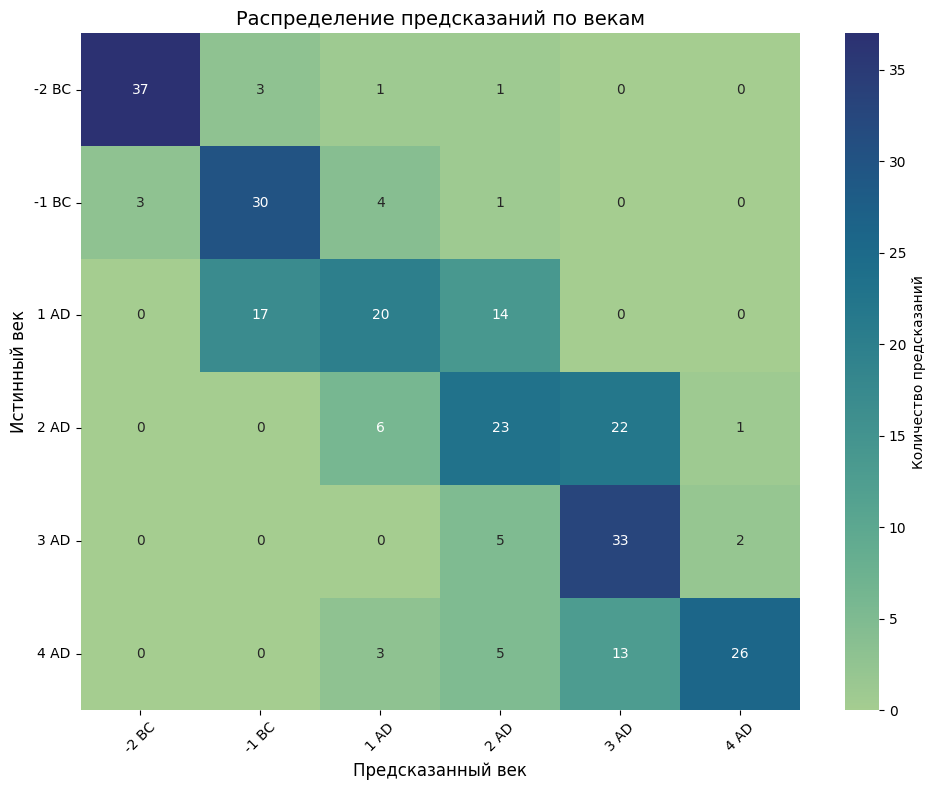

In [143]:
plot_century_heatmap(stack_true, stack_pred)

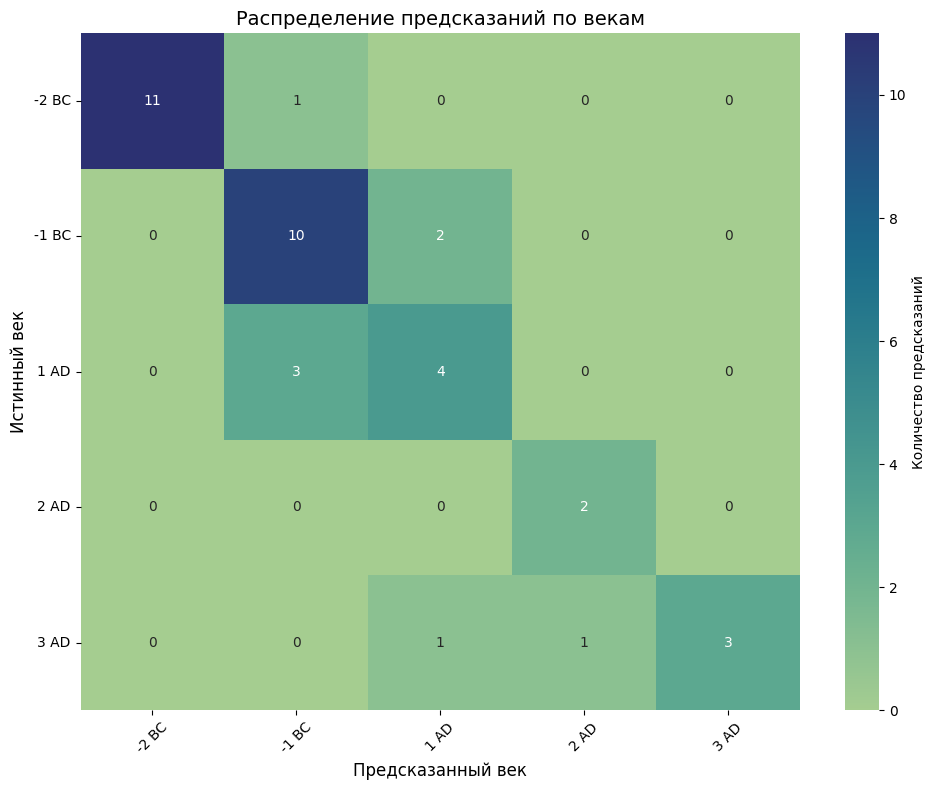

In [ ]:
plot_century_heatmap(stack_true, stack_pred)

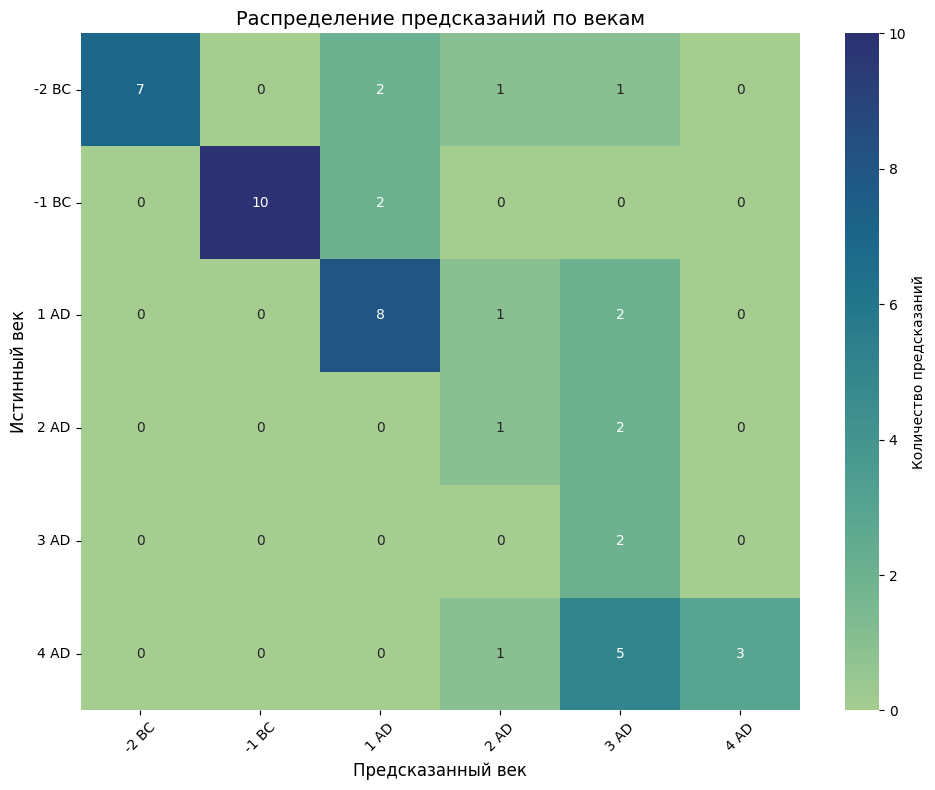

In [ ]:
# 2bc - 4ad
plot_century_heatmap(stack_true, stack_pred)

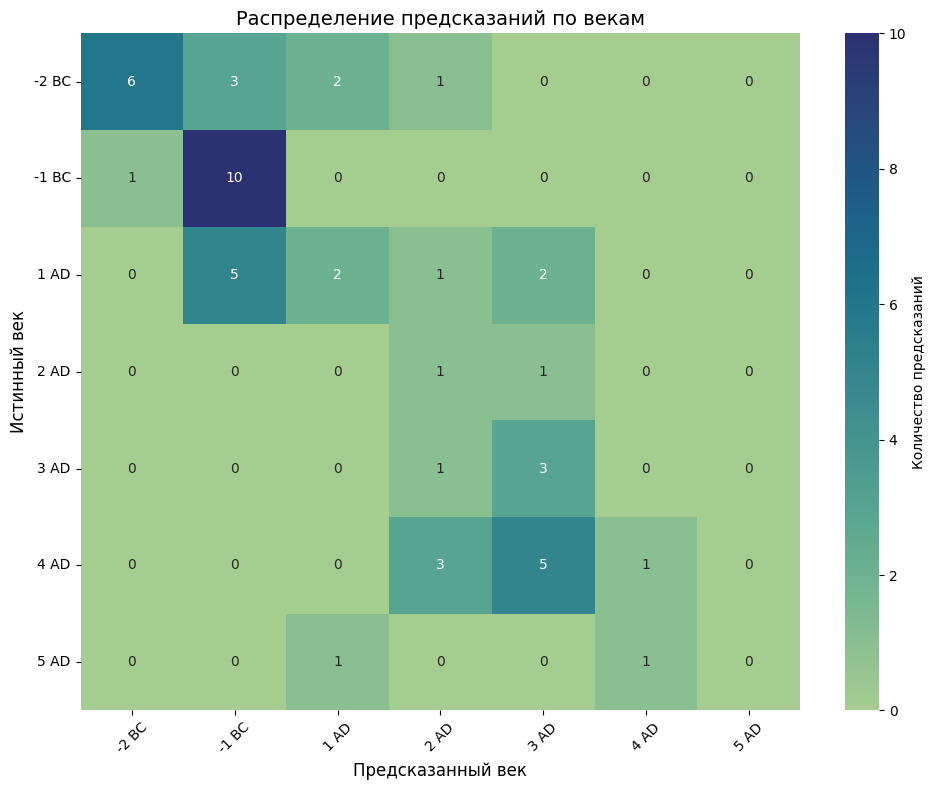

In [ ]:
# 2bc - 5ad
plot_century_heatmap(stack_true, stack_pred)

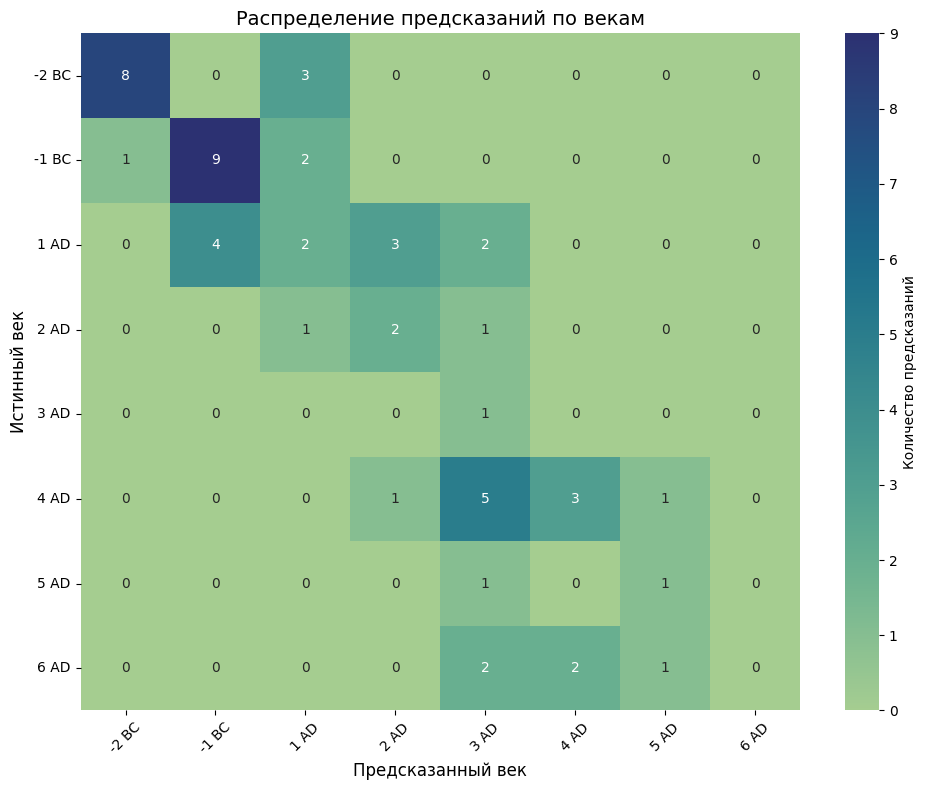

In [ ]:
# 2bc - 6ad
plot_century_heatmap(stack_true, stack_pred)

**4.4. Тестирование модели на развернутых корпусах (обучаем на всем коротком литературном)**

In [27]:
len(ldist_ise)

540

In [184]:
# Даные для теста
new_ldist_ise = ldist_ise[~(ldist_ise['num_chars'] < 100)].reset_index(drop=True)
new_ldist_ise = new_ldist_ise[~(new_ldist_ise['century'] > 3)].reset_index(drop=True)

In [185]:
len(new_ldist_ise)

225

_______________________________________________________

In [82]:
len(cleaned_papyri)

703

In [30]:
new_all_papyri = cleaned_papyri[~(cleaned_papyri['num_chars'] < 1000)].reset_index(drop=True)
new_all_papyri = new_all_papyri[~(new_all_papyri['century'] > 3)].reset_index(drop=True)

In [84]:
len(new_all_papyri)

35

___________________________________________________________________________________

In [188]:
# Данные для трейна
new_final_ise = final_ise.copy()
new_final_ise = new_final_ise[~(new_final_ise['century'] > 3)].reset_index(drop=True)

In [189]:
len(new_final_ise)

191

In [32]:
texts = new_final_ise['text']
dates = new_final_ise['mid_date']

In [34]:
# Тестовые корпуса: не точно датированные литературные и все документальные тексты
test_ise = new_ldist_ise.copy()
test_ise_prose = test_ise.loc[test_ise['genre'] == 'prose']
#test_pap = new_all_papyri.copy()

#test_pap['text'] = test_pap['text'].apply(clean_text)
test_ise['text'] = test_ise['text'].apply(clean_text)

In [35]:
# Визуализация попадания в интервал
def plot_interval_graph(df):
  sorted_df = df.sort_values('upper_date', ascending=False).reset_index(drop=True)

  plt.figure(figsize=(14, 7))

  x = np.arange(len(sorted_df))

  # Границы дат (синий цвет с заливкой)
  plt.plot(x, sorted_df['upper_date'], color='royalblue', label='Upper date', linewidth=1)
  plt.plot(x, sorted_df['lower_date'], color='royalblue', label='Lower date', linewidth=1)
  plt.fill_between(x, sorted_df['lower_date'], sorted_df['upper_date'], color='royalblue', alpha=0.1)

  # Предсказания (красный цвет)
  plt.plot(x, sorted_df['pred_date'], color='crimson', label='Predicted date', linewidth=1.5, marker='o', markersize=3)

  # Настройки графика
  plt.title('Временной интервал vs Предсказание', fontsize=14, pad=20)
  plt.xlabel('Текст', fontsize=12)
  plt.ylabel('Год', fontsize=12)
  plt.legend(fontsize=12, loc='upper right')
  plt.grid(True, alpha=0.2)

  plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))

  plt.tight_layout()
  plt.show()

In [36]:
# Функция для обучения и оценки работы модели на расширенном корпусе
def evaluate_date_prediction(model, train_texts, train_dates, test_df):

    test_df = test_df.copy()

    tf_idf = TfidfVectorizer(ngram_range=(1, 5), max_features=5000)

    # Преобразование тренировочных и тестовых данных
    X_train = tf_idf.fit_transform(train_texts)
    y_train = train_dates
    X_test = tf_idf.transform(test_df['text'])

    # Проверка на GP
    is_gp = (hasattr(model, '__class__') and
          'GaussianProcess' in model.__class__.__name__)

    if is_gp:
      X_train = X_train.toarray()
      X_test = X_test.toarray()

    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание
    test_df['pred_date'] = model.predict(X_test)

    # Функция для определения отклонения от диапазона дат
    def calculate_error(row):
        pred = row['pred_date']
        lower = row['lower_date']
        upper = row['upper_date']

        if lower <= pred <= upper:
            return 0.0
        return min(abs(pred - lower), abs(pred - upper))

    # Расчет ошибок
    test_df['error'] = test_df.apply(calculate_error, axis=1)

    # Метрики ошибки
    stats = {
        "mean_error": test_df['error'].mean(),
        "p50_error": np.percentile(test_df['error'], 50),
        "p90_error": np.percentile(test_df['error'], 90),
        "p100_error": test_df['error'].max(),
        "hit_rate": (test_df['error'] == 0).mean()  # доля попаданий в интервал
    }

    stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])

    return stats_df, test_df

In [176]:
# Алгоритмы
# GP
kernel_best = ConstantKernel(0.5) * RBF(length_scale=0.5)
gp_best = GaussianProcessRegressor(kernel=kernel_best, alpha=0.1)

# Стекинг с конвертацией
to_dense = FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X)
gp_pipeline = make_pipeline(to_dense, gp_best)
estimators = [('svr', svr_best), ('boost', gb_best), ('gp', gp_pipeline)]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=xt_best
)

# SVR
svr_best = SVR(C=100, epsilon=0.1, kernel='rbf')

In [102]:
# SVR
svr_metrics_prose, svr_dated_ise_prose = evaluate_date_prediction(svr_best, texts, dates, test_ise_prose)

In [157]:
# GP
gp_metrics_prose, gp_dated_ise_prose = evaluate_date_prediction(gp_best, texts, dates, test_ise_prose)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
# norm
gp_dated_ise_prose

text  id        n  \
1   Quin etiam saepe prava magis quam bona consili...  LC       19   
2   Hominem sapientem et justum esse liberisque su...  LC        1   
3   Ea demum magna voluptas est C. Sallusti aequal...  LC        3   
4   Pandora Prometheus Iapeti filius primus homine...  IT  LAT0051   
6   DE AGRORUM QUALITATE qualitates sunt tres una ...  IT  LAT0588   
7   Cum ad instruendam rei militaris scientiam unu...  IT  LAT0588   
8   Praef multi ex Romanis etiam consularis dignit...  IT  LAT0201   
11  Cogitate cum animis vetris si quid vos per lab...  IT  LAT0236   
12  Quoniam de cultu agrorum abunde primo volumine...  IT  LAT0239   
13  Quoniam comperi nonnullos qui se plurimum sape...  IT  LAT0264   
14  LIBER PRIMUS Orbis situm dicere aggredior impe...  IT  LAT0266   
15  Cogitanti mihi et cum animo meo Octavi boni et...  IT  LAT0267   
16  Omne peccatum actio est actio autem omnis volu...  IT  LAT0272   
18  Inter haec Alexander ad conducendum ex Pelopon...  IT  LAT0325   
19  Condiciones agrorum per totam Italiam diversas...  IT  LAT0339   
20  Divisi et assignati agri non unius sunt condic...  IT  LAT0340   
21  Quaestorii dicuntur agri quos ex hoste captos ...  IT  LAT0341   
22  Notum est omnibus Celse penes te studiorum nos...  IT  LAT0342   
23  Limites lege late patere debent secundum const...  IT  LAT0345   
24  Nunc de generibus controversiarum perscribam q...  IT  LAT0346   
25  Nunc papilionum tensionem cohortium supra scri...  IT  LAT0347   
26  Inter omnes mensurarum ritus sive actus eminen...  IT  LAT0348   
27  Territorii aeque iuris controversia agitatur q...  IT  LAT0349   
28  Volenti tibi omnia nosse scripsi hunc librum m...  IT  LAT0351   
29  Etsi te studio grammaticae artis inductum non ...  IT  LAT0355   
30  . . iucundiora alia reperiri queunt ad hoc ut ...  IT  LAT0360   
31  Homerus . ante Romam conditam . annis circiter...  IT  LAT0393   
32  Sed ut vulgari proverbio dicitur Deus ille pra...  IT  LAT0406   
33  cum servus legatus in fuga esset vel longinquo...  IT  LAT0407   
34  Haec oratio dicta est Cn. Pompeio Magno II M. ...  IT  LAT0425   
36  LIBER PRIMUS Cum omnis res ab imperatore deleg...  IT  LAT0588   
38  Liber Primus [ a Consiliario eo tempore quo ad...  IT  LAT0621   
39  LIBER PRIMUS Hoc schema duobus modis fieri et ...  IT  LAT0632   
40  De origine urbis Rom et temporibus ejus de die...  IT  LAT0665   
41  UXOR TYRANNICIDA QUINQUE CUM TYRANNO PROXIMI F...  IT  LAT0784   
42  Ex libris Acholii qui magister admissionum Val...  IT  LAT0846   
43  Idem Curio sed et M. Actorius Naso auctores su...  IT  LAT0849   
44  Regula exigit ueritatis ut primo omnium credam...  IT  LAT0865   
45  Cap Graece Latine numerus vocatur est aequaliu...  IT  LAT0913   
46  DE MVSICA Prior est musica inventione metrica ...  IT  LAT0914   
47  In singularibus verbis multa dubia habentur pe...  IT  LAT0916   
48  DECLAMATIO MAIOR I [ Quidam cui erat filius ca...  IT  LAT0934   

                                    author                  date  century  \
1   attributed to Gaius Sallustius Crispus         cent. 1 B. C.       -1   
2                       Aelianus, Claudius           02-03 cent.        2   
3      attributed to Marcus Tullius Cicero             -01 cent.        1   
4                    Hyginus, Gaius Iulius  cent. 1 B. C.-1 A.D.       -1   
6                 Frontinus, Sextus Iulius         cent. 1 A. D.        1   
7                 Frontinus, Sextus Iulius         cent. 1 A. D.        1   
8                Iustinus Iunianus, Marcus         cent. 3 A. D.        3   
11                    Cato Porcius, Marcus     ca. 200-149 B. C.       -2   
12      Columella, Lucius Iunius Moderatus         cent. 1 A. D.        1   
13                                Arnobius       cent. 3-4 A. D.        3   
14                         Mela, Pomponius         cent. 1 A. D.        1   
15                  Minucius Felix, Marcus         cent. 2 A. D.        2   
16                       [Auctor ince

In [62]:
# Расширенный 1AD
gp_metrics

Value
mean_error   54.982228
p50_error    21.000071
p90_error   170.704886
p100_error  321.001505
hit_rate      0.346667

In [ ]:
gp_metrics

Value
mean_error   53.019177
p50_error    16.443541
p90_error   162.922694
p100_error  318.013945
hit_rate      0.413333

In [ ]:
# 2bc - 6ad
gp_metrics

Value
mean_error   85.534681
p50_error    67.554307
p90_error   197.569097
p100_error  389.600393
hit_rate      0.184906

In [103]:
svr_metrics_prose

Value
mean_error   49.433923
p50_error    14.229756
p90_error   169.576149
p100_error  213.860478
hit_rate      0.380952

In [ ]:
gp_metrics_prose

Value
mean_error   38.550104
p50_error     0.000000
p90_error   127.101425
p100_error  185.396613
hit_rate      0.523810

In [74]:
# Расширенный 1AD
gp_metrics_prose

Value
mean_error   40.943952
p50_error     3.810505
p90_error   130.670848
p100_error  193.643715
hit_rate      0.428571

In [ ]:
# 2bc - 6ad
gp_metrics_prose

Value
mean_error   85.807428
p50_error    66.053233
p90_error   203.332376
p100_error  389.600393
hit_rate      0.208333

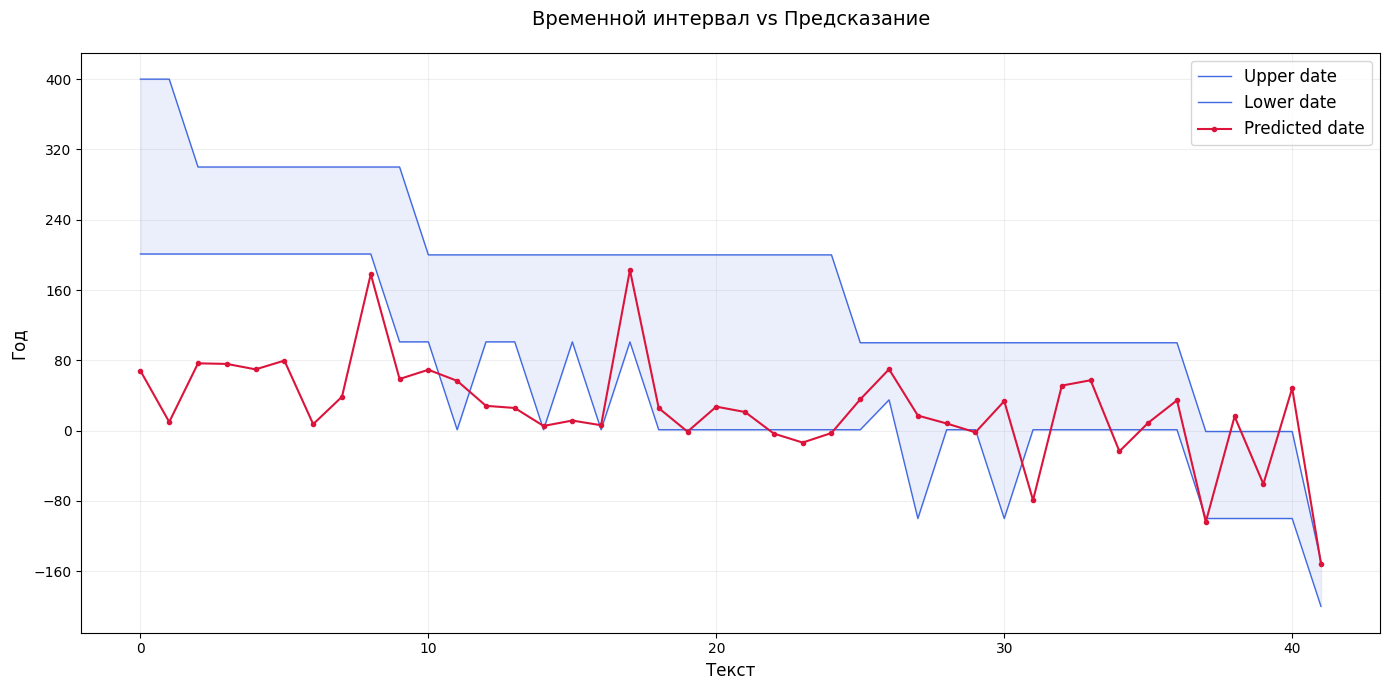

In [64]:
# Расширенный 1AD
plot_interval_graph(gp_dated_ise.loc[gp_dated_ise['genre'] == 'prose'])

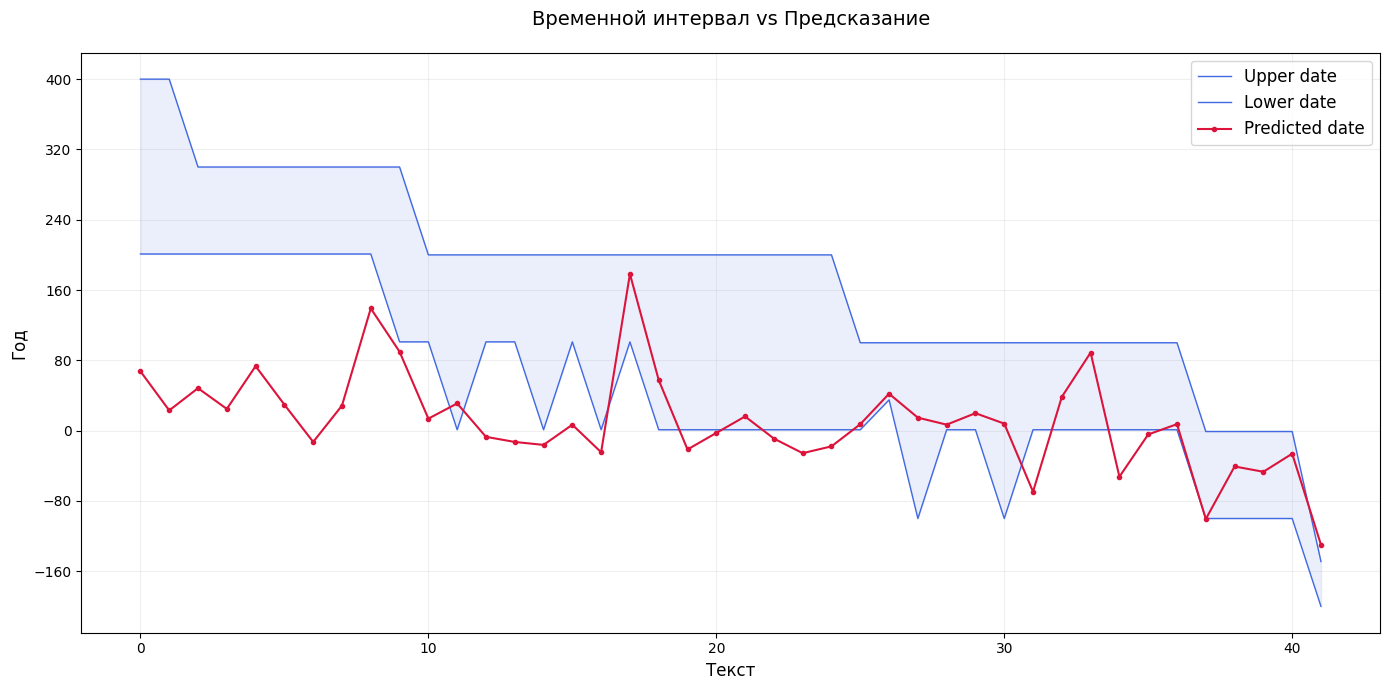

In [104]:
plot_interval_graph(svr_dated_ise_prose)

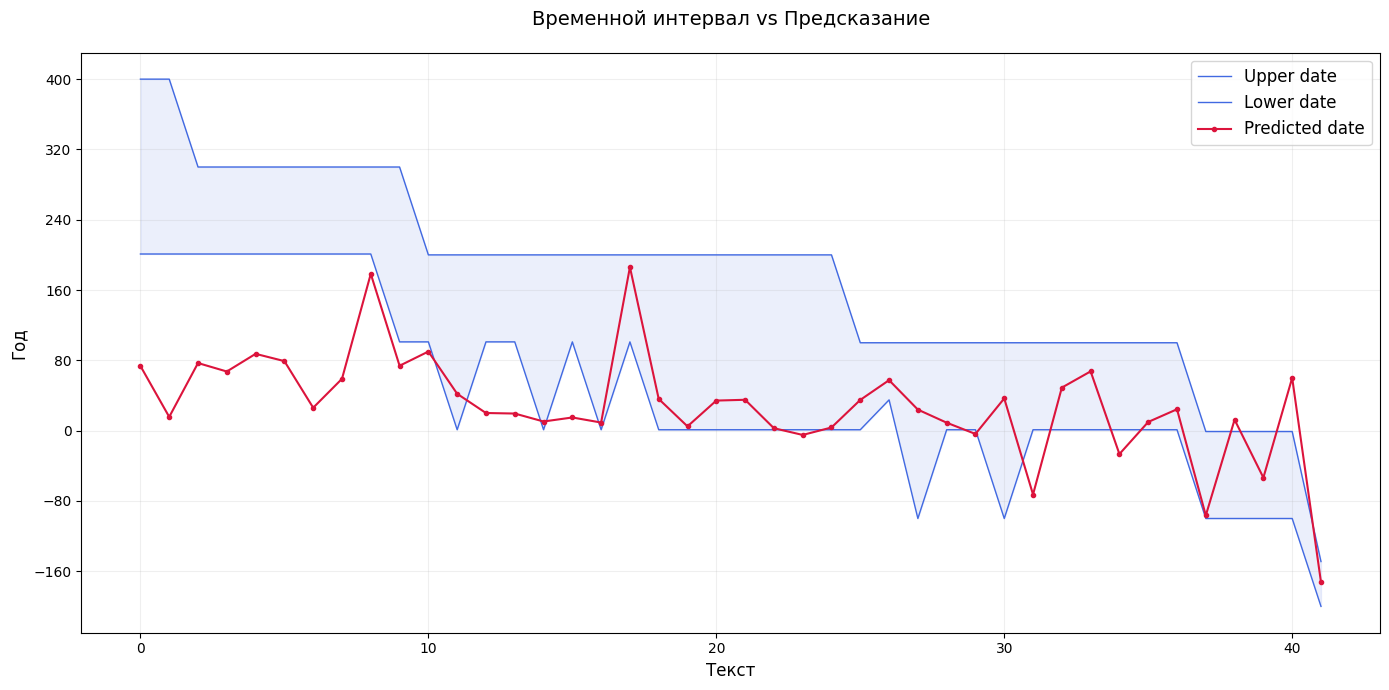

In [ ]:
plot_interval_graph(gp_dated_ise_prose)

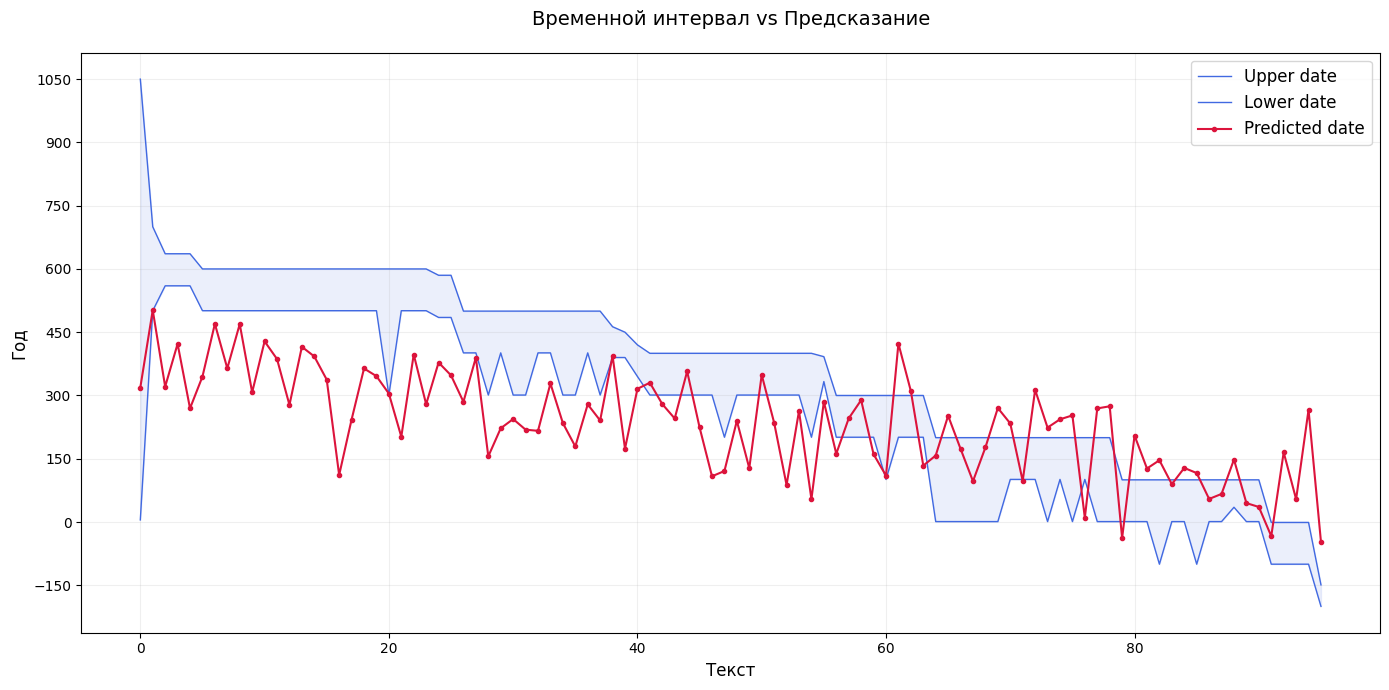

In [ ]:
#2bc - 6ad
plot_interval_graph(gp_dated_ise_prose)

In [27]:
# Стекинг
stack_metrics_prose, stack_dated_ise_prose = evaluate_date_prediction(stack, texts, dates, test_ise_prose)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: C

In [53]:
# Расширенный !AD
stack_metrics

Value
mean_error   61.250191
p50_error    30.617250
p90_error   172.192120
p100_error  315.261036
hit_rate      0.360000

In [ ]:
stack_metrics

Value
mean_error   74.043913
p50_error    36.586091
p90_error   189.703394
p100_error  337.625484
hit_rate      0.342222

In [ ]:
# 2bc -6ad
stack_metrics

Value
mean_error   83.565034
p50_error    61.796431
p90_error   197.688623
p100_error  385.329861
hit_rate      0.237736

In [106]:
stack_metrics_prose

Value
mean_error   41.782956
p50_error     0.000000
p90_error   145.094834
p100_error  182.893667
hit_rate      0.523810

In [78]:
# Расширенный 1AD
stack_metrics_prose

Value
mean_error   46.437053
p50_error    16.697276
p90_error   167.368310
p100_error  211.890278
hit_rate      0.357143

In [ ]:
# 2bc - 6ad
stack_metrics_prose

Value
mean_error   87.531715
p50_error    79.852899
p90_error   181.022345
p100_error  329.829087
hit_rate      0.229167

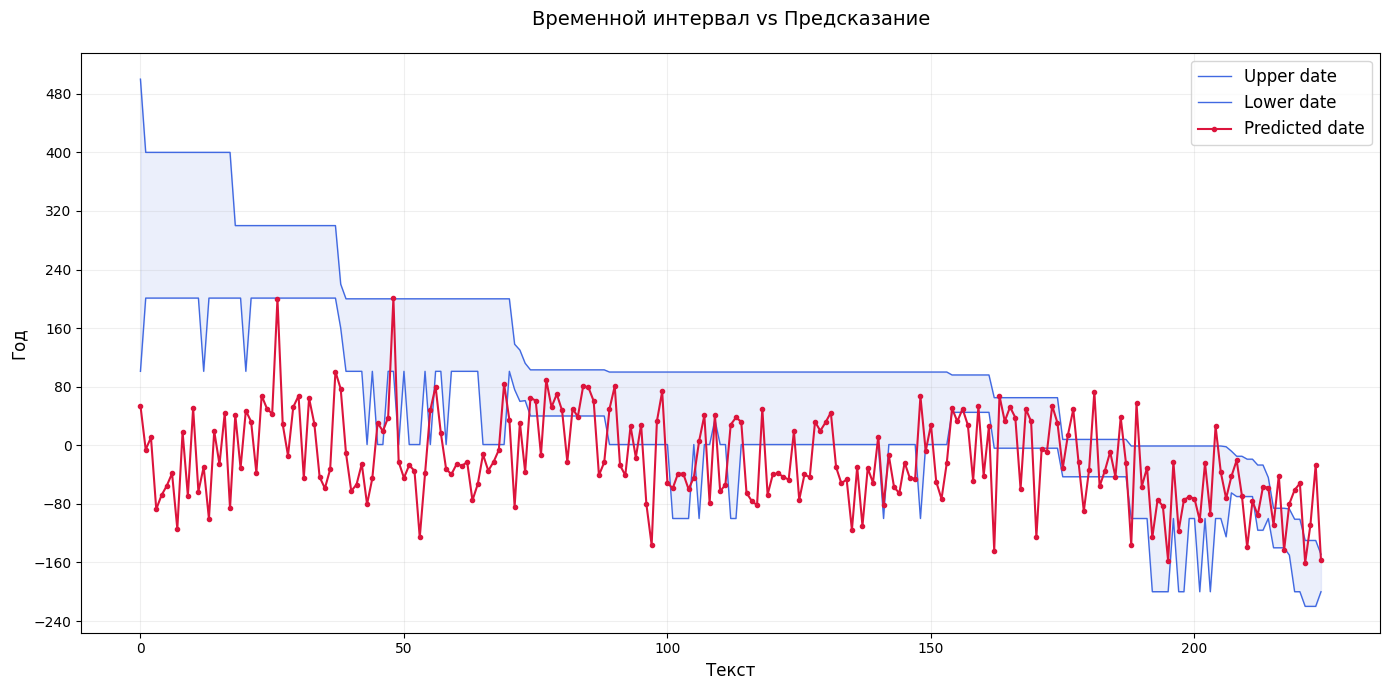

In [54]:
# Расширенный !AD
plot_interval_graph(stack_dated_ise)

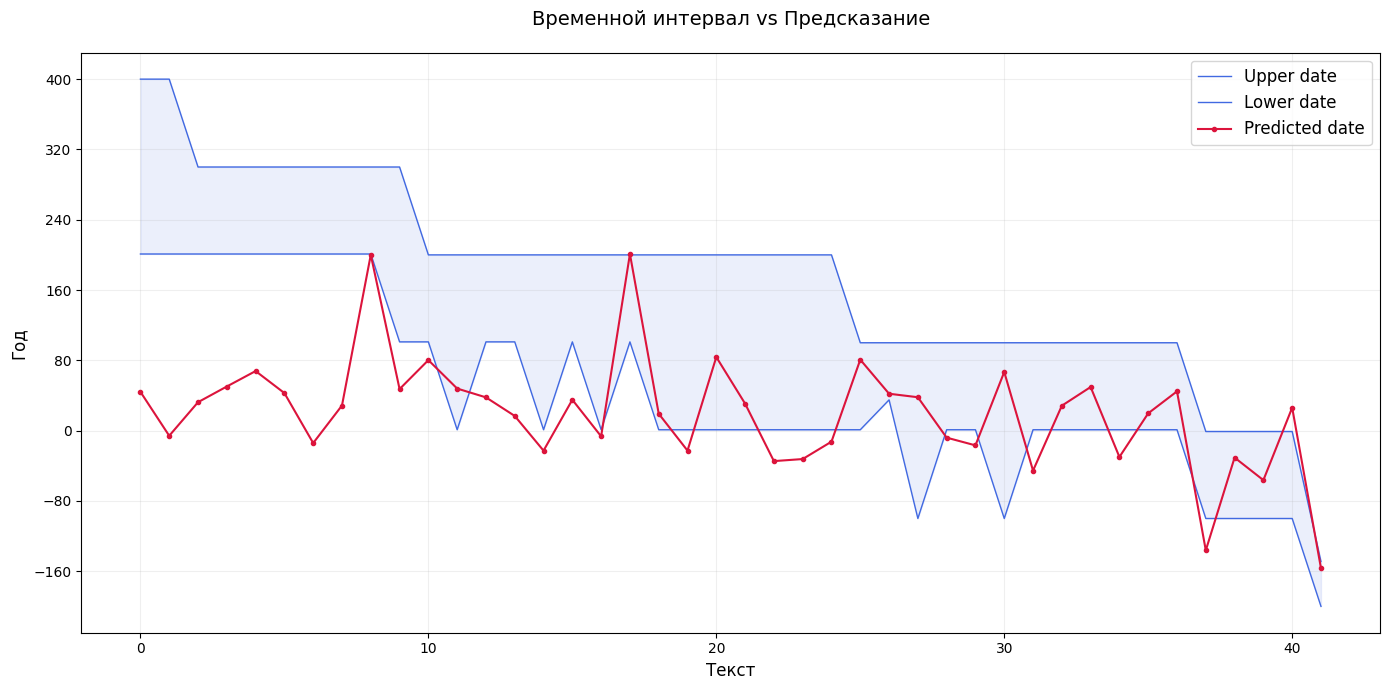

In [60]:
# Расширенный 1AD
plot_interval_graph(stack_dated_ise.loc[stack_dated_ise['genre'] == 'prose'])

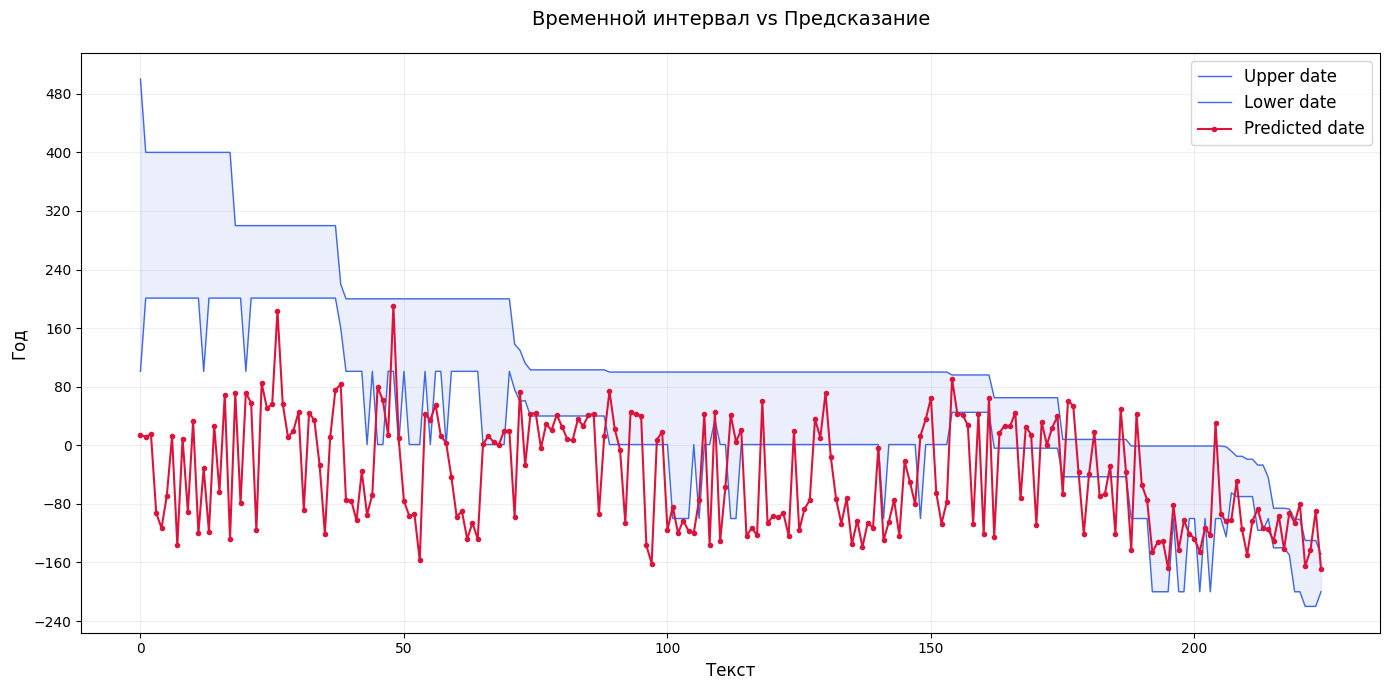

In [ ]:
plot_interval_graph(stack_dated_ise)

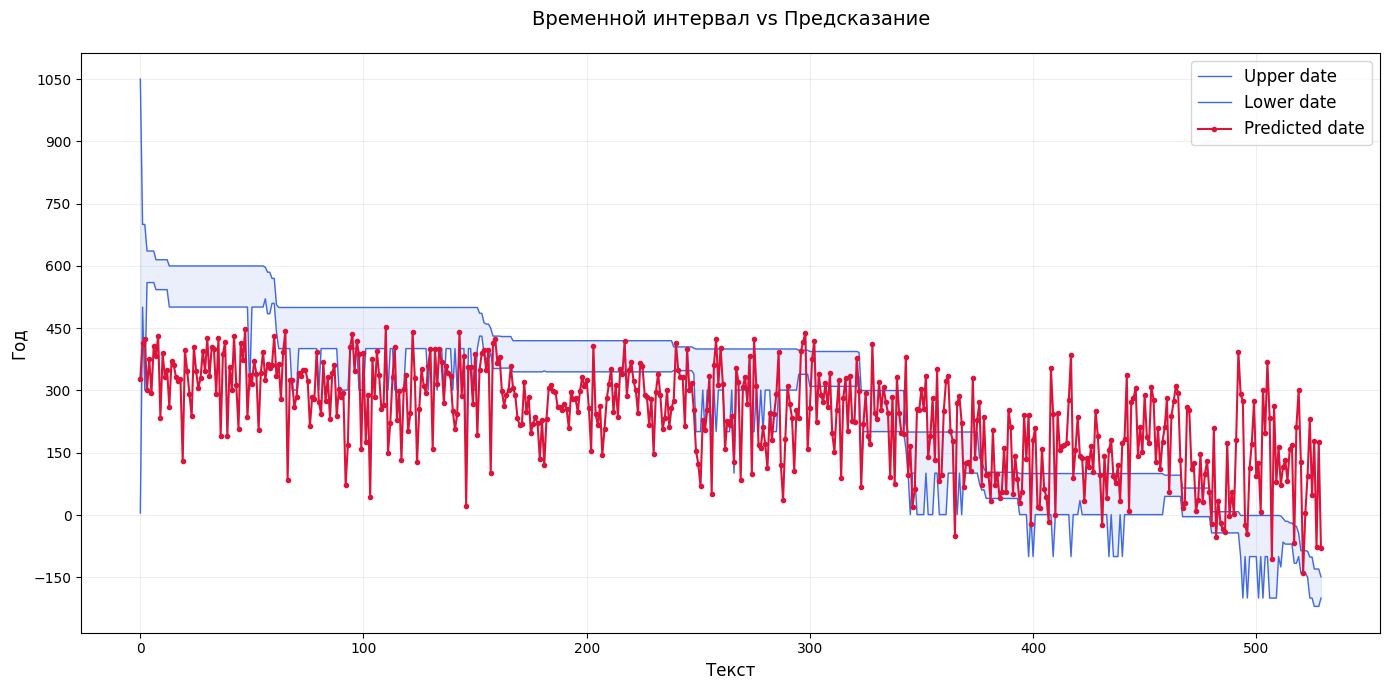

In [ ]:
# 2bc - 6ad
plot_interval_graph(stack_dated_ise)

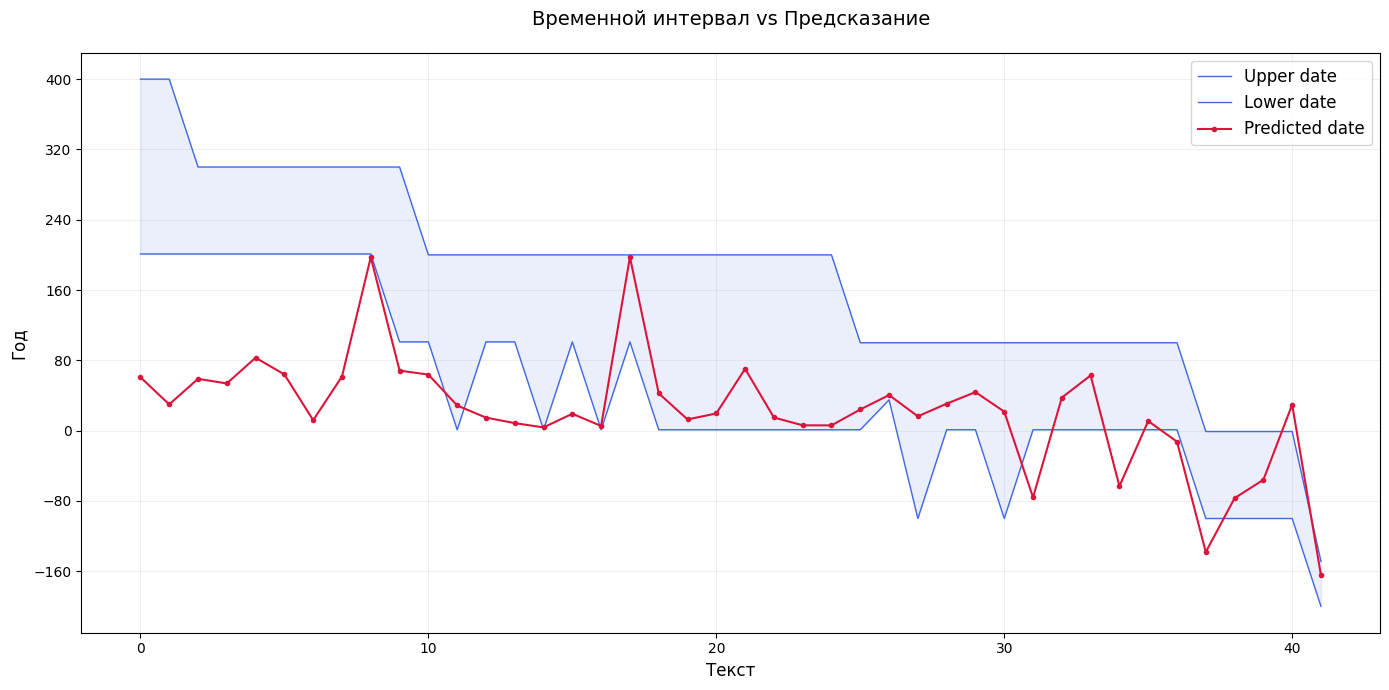

In [ ]:
plot_interval_graph(stack_dated_ise_prose)

In [131]:
len(stack_dated_ise_prose)

42

In [136]:
common_authors = set(final_ise['author']).intersection(set(stack_dated_ise_prose['author']))
print("Общие авторы:", common_authors)

Общие авторы: {'[Auctor incertus]', 'Quintilianus, Marcus Fabius', 'Cato Porcius, Marcus'}


In [169]:
stack_dated_ise_prose.loc[stack_dated_ise_prose['pred_date'] < 0]

text  id        n  \
1   Quin etiam saepe prava magis quam bona consili...  LC       19   
3   Ea demum magna voluptas est C. Sallusti aequal...  LC        3   
11  Cogitate cum animis vetris si quid vos per lab...  IT  LAT0236   
16  Omne peccatum actio est actio autem omnis volu...  IT  LAT0272   
19  Condiciones agrorum per totam Italiam diversas...  IT  LAT0339   
31  Homerus . ante Romam conditam . annis circiter...  IT  LAT0393   
34  Haec oratio dicta est Cn. Pompeio Magno II M. ...  IT  LAT0425   
39  LIBER PRIMUS Hoc schema duobus modis fieri et ...  IT  LAT0632   

                                    author               date  century  \
1   attributed to Gaius Sallustius Crispus      cent. 1 B. C.       -1   
3      attributed to Marcus Tullius Cicero          -01 cent.        1   
11                    Cato Porcius, Marcus  ca. 200-149 B. C.       -2   
16                       [Auctor incertus]        cent.01B.C.       -1   
19                        Flaccus, Siculus    cent. 1-2 A. D.        1   
31                        Nepos, Cornelius       cent. 1 B.C.       -1   
34                      Pedianus, Asconius      cent. 1 A. D.        1   
39                 Lupus, Publius Rutilius      cent. 1 A. D.        1   

                                       title  genre  \
1   Ad Caesarem Senem de†Re†Publica Epistula  prose   
3                    Invectiva in Sallustium  prose   
11                                 Orationes  prose   
16                                Sententiae  prose   
19                  De condicionibus agrorum  prose   
31                           Fragmenta varia  prose   
34                               Commentarii  prose   
39    De figuris sententiarum et elocutionis  prose   

                                                  url  lower_date  mid_date  \
1   http://penelope.uchicago.edu/Thayer/E/Roman/ho...        -100       -51   
3   http://penelope.uchicago.edu/Thayer/E/Roman/ho...           1        50   
11  IntraText Digital Library http://www.intratext...        -200      -175   
16  IntraText Digital Library http://www.intratext...        -100       -51   
19  IntraText Digital Library http://www.intratext...           1       100   
31  IntraText Digital Library http://www.intratext...        -100       -51   
34  IntraText Digital Library http://www.intratext...           1        50   
39  IntraText Digital Library http://www.intratext...           1        50   

    upper_date  num_chars   pred_date      error  
1           -1      13461 -142.307226  42.307226  
3          100      20907  -69.046238  70.046238  
11        -149       5939 -167.646857   0.000000  
16          -1      10852  -53.724933   0.000000  
19         200      41086   -0.557488   1.557488  
31          -1       1950  -78.662587   0.000000  
34         100     156468   -5.413095   6.413095  
39         100      52927  -68.358706  69.358706

In [167]:
gp_dated_ise_prose.loc[gp_dated_ise_prose['upper_date'] == 200]

text  id        n  \
15  Cogitanti mihi et cum animo meo Octavi boni et...  IT  LAT0267   
19  Condiciones agrorum per totam Italiam diversas...  IT  LAT0339   
20  Divisi et assignati agri non unius sunt condic...  IT  LAT0340   
21  Quaestorii dicuntur agri quos ex hoste captos ...  IT  LAT0341   
22  Notum est omnibus Celse penes te studiorum nos...  IT  LAT0342   
23  Limites lege late patere debent secundum const...  IT  LAT0345   
24  Nunc de generibus controversiarum perscribam q...  IT  LAT0346   
25  Nunc papilionum tensionem cohortium supra scri...  IT  LAT0347   
26  Inter omnes mensurarum ritus sive actus eminen...  IT  LAT0348   
27  Territorii aeque iuris controversia agitatur q...  IT  LAT0349   
30  . . iucundiora alia reperiri queunt ad hoc ut ...  IT  LAT0360   
32  Sed ut vulgari proverbio dicitur Deus ille pra...  IT  LAT0406   
33  cum servus legatus in fuga esset vel longinquo...  IT  LAT0407   
41  UXOR TYRANNICIDA QUINQUE CUM TYRANNO PROXIMI F...  IT  LAT0784   
47  In singularibus verbis multa dubia habentur pe...  IT  LAT0916   

                         author             date  century  \
15       Minucius Felix, Marcus    cent. 2 A. D.        2   
19             Flaccus, Siculus  cent. 1-2 A. D.        1   
20             Flaccus, Siculus  cent. 1-2 A. D.        1   
21             Flaccus, Siculus  cent. 1-2 A. D.        1   
22                       Balbus  cent. 1-2 A. D.        1   
23          Hyginus: Gromaticus  cent. 1-2 A. D.        1   
24          Hyginus: Gromaticus  cent. 1-2 A. D.        1   
25          Hyginus: Gromaticus  cent. 1-2 A. D.        1   
26          Hyginus: Gromaticus  cent. 1-2 A. D.        1   
27          Hyginus: Gromaticus  cent. 1-2 A. D.        1   
30               Gellius, Aulus    cent. 2 A. D.        2   
32  Balbus, [Pseudo-] Caecilius    cent. 2 A. D.        2   
33  Caecilius Africanus, Sextus    cent. 2 A. D.        2   
41           Calpurnius Flaccus  cent. 1-2 A. D.        1   
47               Caper, Flavius    cent. 2 A. D.        2   

                                 title  genre  \
15                            Octavius  prose   
19            De condicionibus agrorum  prose   
20            De divisis et assignatis  prose   
21                De quaestoriis agris  prose   
22  Expositio et ratio omnium formarum  prose   
23                        De limitibus  prose   
24        De generibus controversiarum  prose   
25           De munitionibus castrorum  prose   
26                         Constitutio  prose   
27            De condicionibus agrorum  prose   
30                      Noctes Atticae  prose   
32              De nugis philosophorum  prose   
33                         Quaestiones  prose   
41                       Declamationes  prose   
47                    De verbis dubiis  prose   

                                                  url  lower_date  mid_date  \
15  IntraText Digital Library http://www.intratext...         101       150   
19  IntraText Digital Library http://www.intratext...           1       100   
20  IntraText Digital Library http://www.intratext...           1       100   
21  IntraText Digital Library http://www.intratext...           1       100   
22  IntraText Digital Library http://www.intratext...           1       100   
23  IntraText Digital Library http://www.intratext...           1       100   
24  IntraText Digital Library http://www.intratext...           1       100   
25  IntraText Digital Library http://www.intratext...           1       100   
26  IntraText Digital Library http://www.intratext...           1       100   
27  IntraText Digital Library http://www.intratext...           1       100   
30  IntraText Digital Library http://www.intratext...         101       150   
32  IntraText Digital Library http://www.intratext...         101       150   
33  IntraText Digital Library http://www.intratext...         101       150   
41  IntraText Digital Library http://www.intratext...       

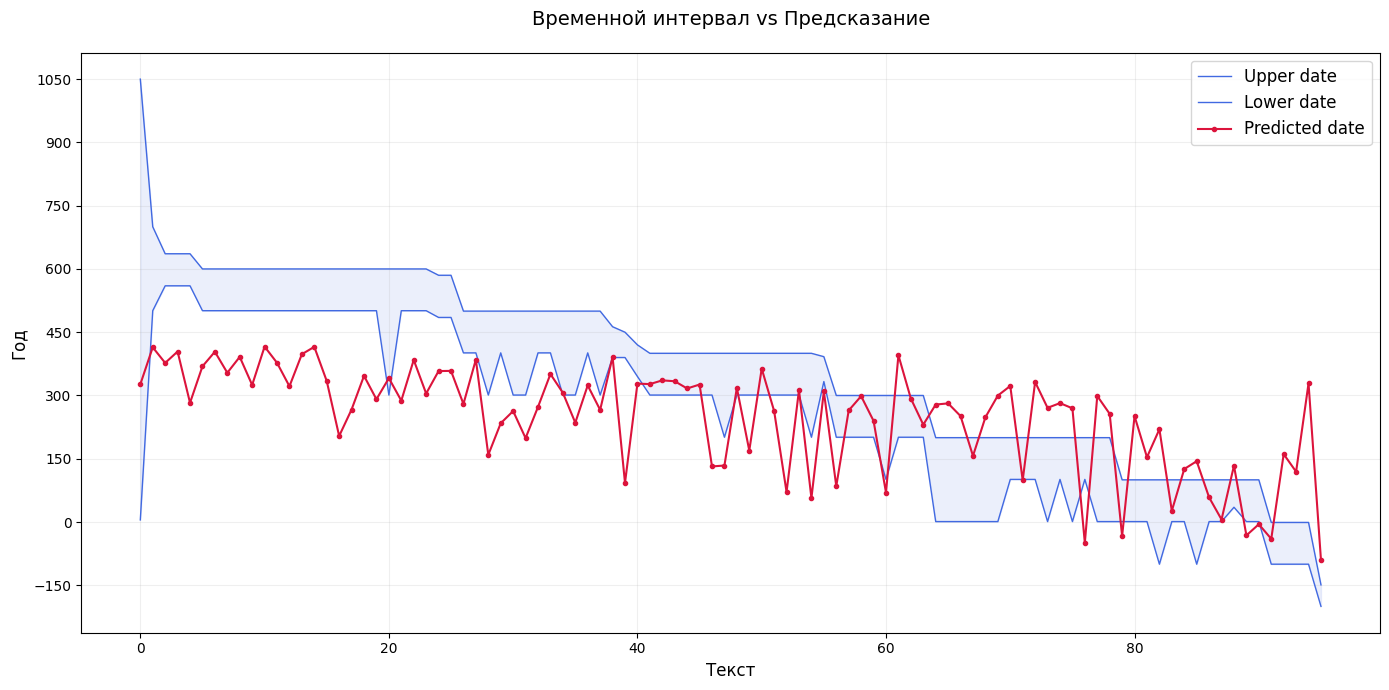

In [ ]:
# 3bc - 6ad
plot_interval_graph(stack_dated_ise_prose)

In [86]:
# GP на папирусах
gp_metrics_pap, gp_dated_pap = evaluate_date_prediction(gp_best, texts, dates, test_pap)

In [ ]:
gp_metrics_pap

Value
mean_error  140.065220
p50_error   148.406925
p90_error   264.511551
p100_error  284.826439
hit_rate      0.114286

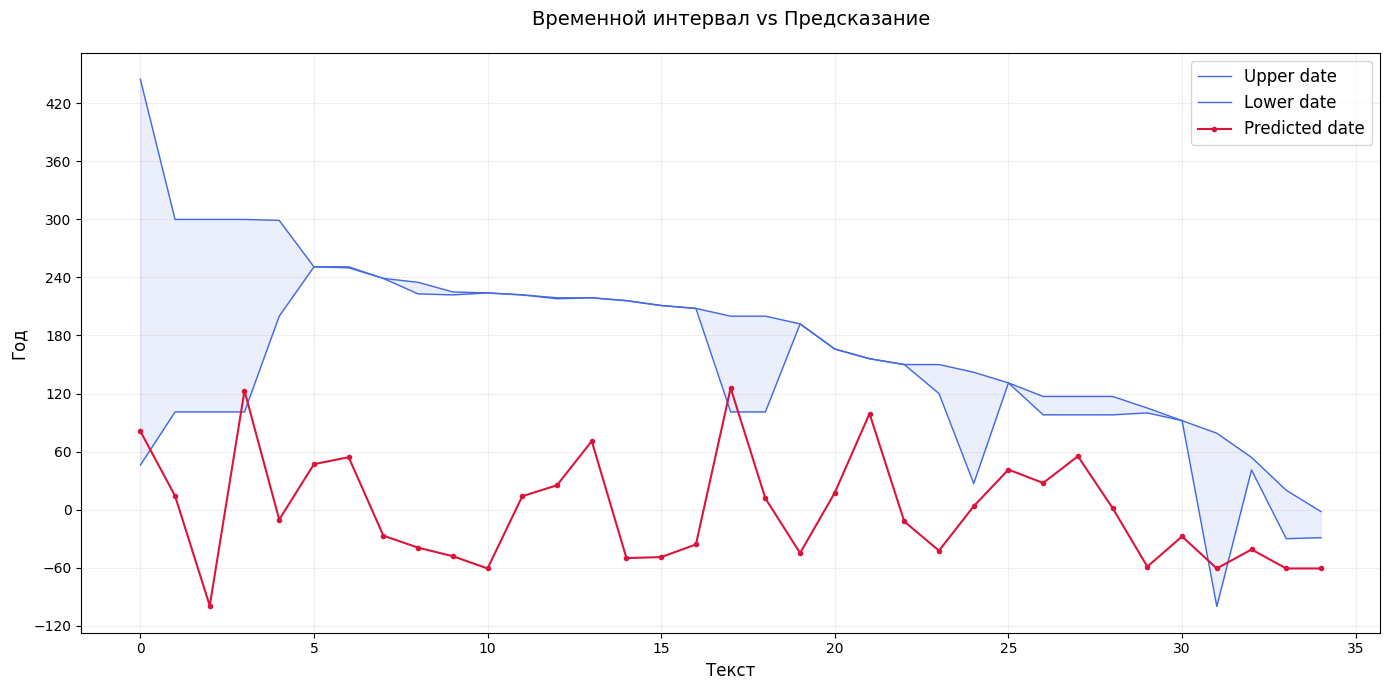

In [ ]:
plot_interval_graph(gp_dated_pap)

In [ ]:
# Стекинг на папирусах
stack_metrics_pap, stack_dated_pap = evaluate_date_prediction(stack, texts, dates, test_pap)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: C

In [ ]:
stack_metrics_pap

Value
mean_error  174.562349
p50_error   172.272583
p90_error   321.636533
p100_error  349.880230
hit_rate      0.085714

____________________________________________

**5. Эксперимент с разделением трейна**

**5.1. Разделение и балансировка корпуса**

In [166]:
# Данные для трейна
new_final_ise = final_ise.copy()
new_final_ise = new_final_ise[~(new_final_ise['century'] > 3)].reset_index(drop=True)

In [167]:
# Даные для теста
new_ldist_ise = ldist_ise[~(ldist_ise['num_chars'] < 100)].reset_index(drop=True)
new_ldist_ise = new_ldist_ise[~(new_ldist_ise['century'] > 3)].reset_index(drop=True)

In [168]:
# Тестовые корпуса: не точно датированные литературные и все документальные тексты
test_ise = new_ldist_ise.copy()
test_ise_prose = test_ise.loc[test_ise['genre'] == 'prose']
#test_pap = new_all_papyri.copy()

#test_pap['text'] = test_pap['text'].apply(clean_text)
test_ise['text'] = test_ise['text'].apply(clean_text)

In [169]:
len(new_final_ise)

191

In [116]:
# Функция для разделения трейна на фрагменты по 5000 символов
def split_text(row, chunk_size=5000):
    text = row['text']
    chunks = []

    # Разбиваем текст на фрагменты по пробелам
    while len(text) > 0:
        if len(text) <= chunk_size:
            chunks.append(text)
            break

        # Находим последний пробел перед chunk_size
        split_pos = text.rfind(' ', 0, chunk_size)

        # Если пробел не найден, принудительно разбиваем по chunk_size
        if split_pos == -1:
            split_pos = chunk_size

        chunk = text[:split_pos]
        chunks.append(chunk)
        text = text[split_pos:].lstrip()

    # Создаем новые строки для каждого фрагмента
    new_rows = []
    for chunk in chunks:
        new_row = row.copy()
        new_row['text'] = chunk
        new_row['num_chars'] = len(chunk)
        new_rows.append(new_row)

    return new_rows

In [191]:
new_rows = []
for _, row in new_final_ise.iterrows():
    new_rows.extend(split_text(row))

newer_final_ise = pd.DataFrame(new_rows).reset_index(drop=True)

In [192]:
len(newer_final_ise)

7162

In [119]:
newer_final_ise['century'].value_counts().sort_index()

century
-2     601
-1    3670
 1    1749
 2     916
 3     226
 4     330
Name: count, dtype: int64

In [120]:
# Функция для балансировки данных внутри одного века (с сохранением пропорции названий длля каждого века)
def balance_century(group, target_count):
    # Получаем список уникальных названий в этом веке
    unique_titles = group['title'].unique()

    # Рассчитываем сколько фрагментов нужно взять от каждого названия
    per_title = target_count // len(unique_titles)
    remainder = target_count % len(unique_titles)

    balanced_rows = []
    used_indices = set()

    # Для каждого названия берем нужное количество фрагментов
    for i, title in enumerate(unique_titles):
        title_rows = group[group['title'] == title]

        # Определяем сколько взять для этого названия
        n_samples = per_title + 1 if i < remainder else per_title

        # Если фрагментов меньше, чем нужно, берем все
        n_samples = min(n_samples, len(title_rows))

        # Выбираем случайные фрагменты
        sampled = title_rows.sample(n=n_samples, replace=False, random_state=42)
        balanced_rows.append(sampled)

    # Собираем все вместе
    balanced_group = pd.concat(balanced_rows, ignore_index=False)
    used_indices.update(balanced_group.index)

    # Если все еще не хватает до target_count из-за недостатка фрагментов в некоторых названиях
    if len(balanced_group) < target_count:
        # Добираем случайные фрагменты из оставшихся
        remaining = group[~group.index.isin(used_indices)]
        needed = target_count - len(balanced_group)
        if len(remaining) >= needed:
            extra = remaining.sample(n=needed, replace=False, random_state=42)
            balanced_group = pd.concat([balanced_group, extra])
    return balanced_group

In [193]:
balanced_dfs = []
target_count = 226
for century in newer_final_ise['century'].unique():
    century_group = newer_final_ise[newer_final_ise['century'] == century]

    if len(century_group) >= target_count:
        # Если в веке больше или равно 226 фрагментов - балансируем
        balanced_century = balance_century(century_group, target_count)
    else:

        continue

    balanced_dfs.append(balanced_century)

# Собираем все вместе
balanced_final_ise = pd.concat(balanced_dfs).reset_index(drop=True)

In [194]:
balanced_final_ise['century'].value_counts().sort_index()

century
-2    226
-1    226
 1    226
 2    226
 3    226
Name: count, dtype: int64

**5.2. Обучение модели**

*5.2.1. Обучение и тест на сокращенном корпусе*

In [ ]:
# Функция для визуализации работы модели по векам
def century_from_year(year):
    if year > 0:
        return (year - 1) // 100 + 1
    else:
        return -((-year - 1) // 100 + 1)


def plot_century_heatmap(y_true, y_pred):

    true_centuries = [century_from_year(y) for y in y_true]
    pred_centuries = [century_from_year(y) for y in y_pred]

    # Создаём список всех веков в данных (учитывая отсутствие 0 века)
    all_centuries = sorted(set(true_centuries + pred_centuries))
    if 0 in all_centuries:
        all_centuries.remove(0)  # Удаляем 0 век, если он случайно появился

    # Создаём матрицу путаницы
    cm = np.zeros((len(all_centuries), len(all_centuries)), dtype=int)

    # Заполняем матрицу
    for true, pred in zip(true_centuries, pred_centuries):
        if true in all_centuries and pred in all_centuries:
            i = all_centuries.index(true)
            j = all_centuries.index(pred)
            cm[i, j] += 1

    # Подписи для оси (BC/AD)
    labels = [f"{c} BC" if c < 0 else f"{c} AD" for c in all_centuries]

    # Рисуем тепловую карту
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Количество предсказаний'})

    plt.title('Распределение предсказаний по векам', fontsize=14)
    plt.xlabel('Предсказанный век', fontsize=12)
    plt.ylabel('Истинный век', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Функция для обучения модели (без аугментации - не хватает памяти)
def train_model(model, texts, dates):

    tf_idf = TfidfVectorizer(ngram_range=(1, 5), max_features=5000)

    # Разделение на выборки
    X_train, X_test, y_train, y_test = train_test_split(texts, dates, test_size=0.2, random_state=42)



    # Векторизация
    X_train_tfidf = tf_idf.fit_transform(X_train)
    X_test_tfidf = tf_idf.transform(X_test)

    # Видоизменение матрицы признаков ля GP
    is_gp = (hasattr(model, '__class__') and
             'GaussianProcess' in model.__class__.__name__)

    if is_gp:
      X_train_tfidf = X_train_tfidf.toarray()
      X_test_tfidf = X_test_tfidf.toarray()

    # Обучение и оценка модели
    model = deepcopy(model)
    model.fit(X_train_tfidf, y_train)

    y_pred = model.predict(X_test_tfidf)
    metrics = calculate_percentile_errors(y_test, y_pred)

    return {
          'model': model,
          'metrics': metrics,
            }, y_test, y_pred

In [174]:
len(balanced_final_ise)

1130

In [175]:
texts = balanced_final_ise['text']
dates = balanced_final_ise['mid_date']

In [ ]:
stack_result, stack_true, stack_pred = train_model(stack, texts, dates)

In [147]:
gp_result, gp_true, gp_pred = train_model(gp_best, texts, dates)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [145]:
pd.DataFrame.from_dict(stack_result['metrics'], orient='index', columns=['Value'])

Value
mae    46.822683
p50    25.872399
p90   111.207936
p100  375.471794
r2      0.832276

In [148]:
pd.DataFrame.from_dict(gp_result['metrics'], orient='index', columns=['Value'])

Value
mae    62.575670
p50    46.098728
p90   132.063229
p100  373.722254
r2      0.776859

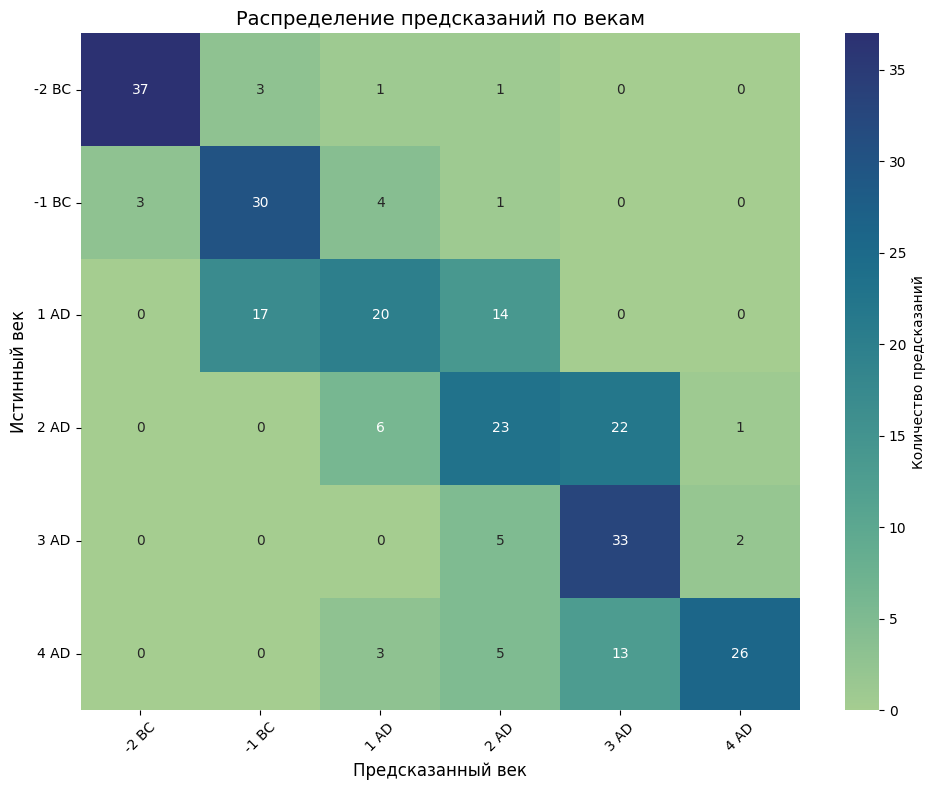

In [146]:
plot_century_heatmap(stack_true, stack_pred)

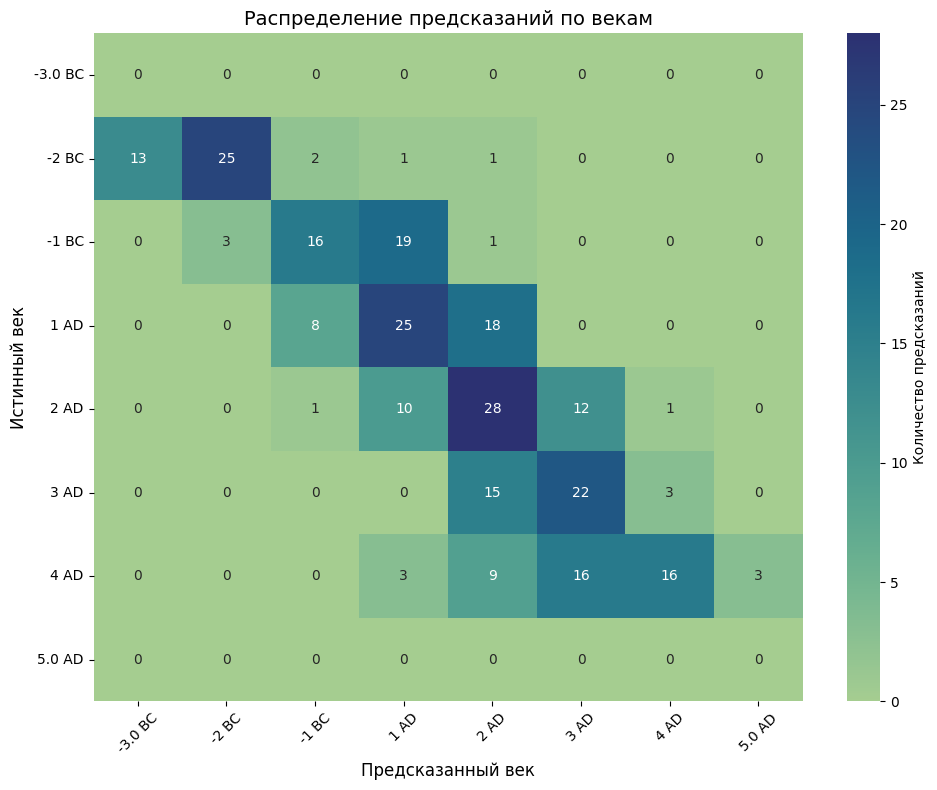

In [149]:
plot_century_heatmap(gp_true, gp_pred)

*5.2.2. Тест на расширенном корпусе*

__________________________________________________________________________

In [ ]:
# Функция для обучения и оценки работы модели на расширенном корпусе
def evaluate_date_prediction(model, train_texts, train_dates, test_df):

    test_df = test_df.copy()

    tf_idf = TfidfVectorizer(ngram_range=(1, 5), max_features=5000)

    # Преобразование тренировочных и тестовых данных
    X_train = tf_idf.fit_transform(train_texts)
    y_train = train_dates
    X_test = tf_idf.transform(test_df['text'])

    # Проверка на GP
    is_gp = (hasattr(model, '__class__') and
          'GaussianProcess' in model.__class__.__name__)

    if is_gp:
      X_train = X_train.toarray()
      X_test = X_test.toarray()

    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание
    test_df['pred_date'] = model.predict(X_test)

    # Функция для определения отклонения от диапазона дат
    def calculate_error(row):
        pred = row['pred_date']
        lower = row['lower_date']
        upper = row['upper_date']

        if lower <= pred <= upper:
            return 0.0
        return min(abs(pred - lower), abs(pred - upper))

    # Расчет ошибок
    test_df['error'] = test_df.apply(calculate_error, axis=1)

    # Метрики ошибки
    stats = {
        "mean_error": test_df['error'].mean(),
        "p50_error": np.percentile(test_df['error'], 50),
        "p90_error": np.percentile(test_df['error'], 90),
        "p100_error": test_df['error'].max(),
        "hit_rate": (test_df['error'] == 0).mean()  # доля попаданий в интервал
    }

    stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])

    return stats_df, test_df

In [162]:
# Функция для теста модели, ОБУЧЕННО НА ФРАГМЕНТАХ
def predict_and_evaluate(test_df, model, chunk_size=5000):

    test_df = test_df.copy()

    tf_idf = TfidfVectorizer(ngram_range=(1, 5), max_features=5000)

    # Разделяем длинные тексты на фрагменты
    chunk_rows = []
    for _, row in test_df.iterrows():
        chunks = split_text(row, chunk_size)
        chunk_rows.extend(chunks)

    chunk_df = pd.DataFrame(chunk_rows)

    # Векторизация
    X_chunks = tf_idf.fit_transform(chunk_df['text'])

    # Предсказываем даты для фрагментов
    chunk_df['pred_date'] = model.predict(X_chunks)

    # Группируем по исходным текстам и вычисляем среднюю дату
    if 'index' in chunk_df.columns:
        # Если в chunk_df есть исходные индексы
        grouped = chunk_df.groupby('index')['pred_date'].median().reset_index()
    else:
        # Если нет индексов, предполагаем, что порядок сохранен
        grouped = chunk_df.groupby(chunk_df.index)['pred_date'].median().reset_index()

    # Объединяем с исходным датафреймом
    test_df = test_df.reset_index().merge(grouped, on='index', how='left')

    # Функция для расчета ошибки
    def calculate_error(row):
        pred = row['pred_date']
        lower = row['lower_date']
        upper = row['upper_date']

        if lower <= pred <= upper:
            return 0.0
        return min(abs(pred - lower), abs(pred - upper))

    # Расчет ошибок
    test_df['error'] = test_df.apply(calculate_error, axis=1)

    # Метрики ошибки
    stats = {
        "mean_error": test_df['error'].mean(),
        "p50_error": np.percentile(test_df['error'], 50),
        "p90_error": np.percentile(test_df['error'], 90),
        "p100_error": test_df['error'].max(),
        "hit_rate": (test_df['error'] == 0).mean()  # доля попаданий в интервал
    }

    stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])

    return stats_df, test_df

In [152]:
len(balanced_final_ise)

1356

In [156]:
texts = balanced_final_ise['text']
dates = balanced_final_ise['mid_date']

In [157]:
# Обучаем модель stack
tf_idf = TfidfVectorizer(ngram_range=(1, 5), max_features=5000)

X = tf_idf.fit_transform(texts)
y = dates

stack = stack.fit(X, y)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [160]:
stack_trained = stack

In [163]:
stack_metrics_prose, stack_dated_ise_prose = predict_and_evaluate(test_ise_prose, stack_trained)

In [164]:
stack_metrics_prose

Value
mean_error   92.593407
p50_error    74.587927
p90_error   216.467663
p100_error  274.726409
hit_rate      0.338710

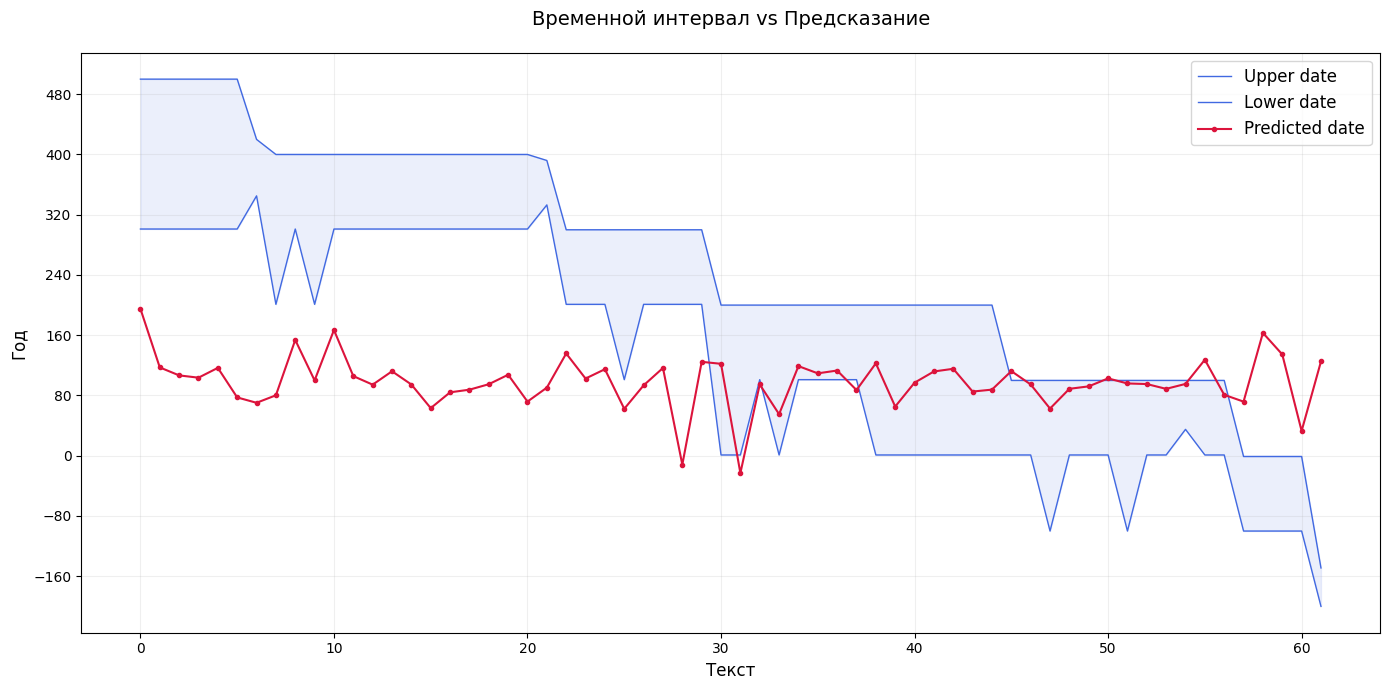

In [165]:
plot_interval_graph(stack_dated_ise_prose)

_________________________________________________________________________________________________

In [177]:
stack_metrics_prose, stack_dated_ise_prose = evaluate_date_prediction(stack, texts, dates, test_ise_prose)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: C

In [129]:
stack_metrics

Value
mean_error   57.967219
p50_error    34.146345
p90_error   152.390513
p100_error  311.398131
hit_rate      0.346667

In [178]:
stack_metrics_prose

Value
mean_error   33.669080
p50_error     2.379391
p90_error   131.339349
p100_error  198.214730
hit_rate      0.452381

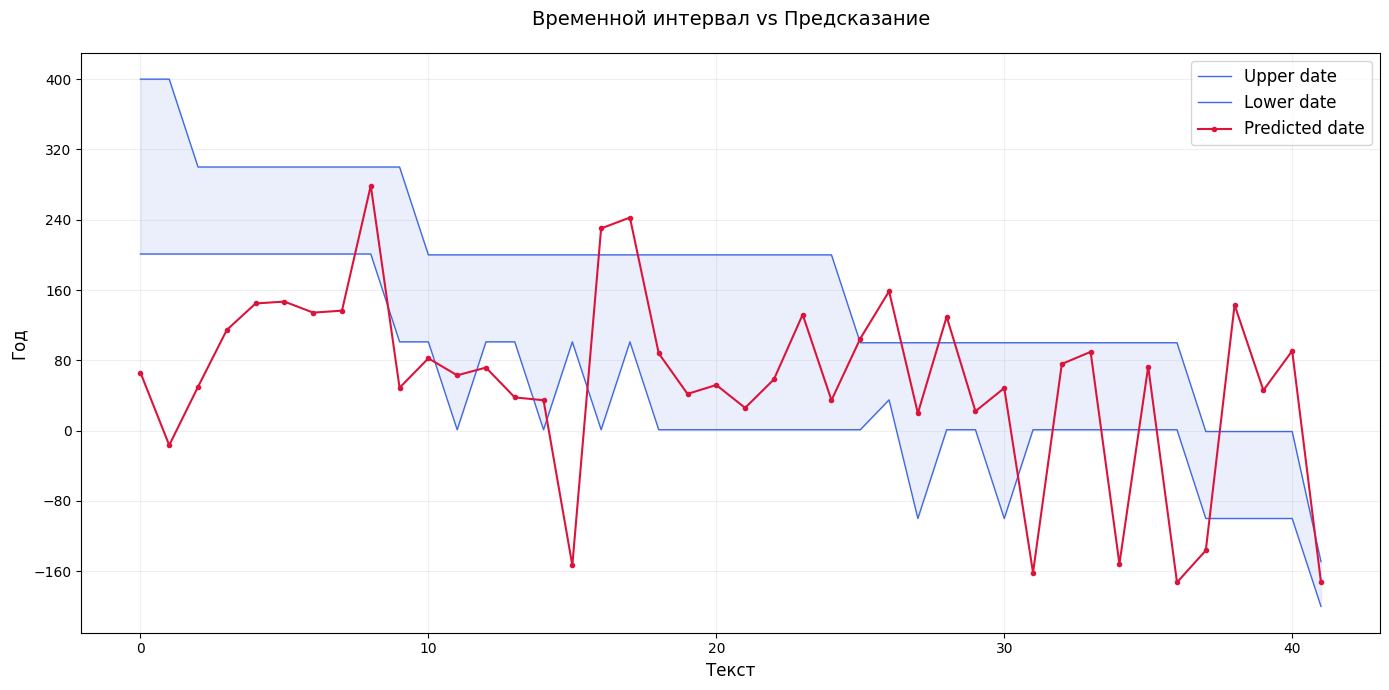

In [134]:
# 2bc - 4ad
plot_interval_graph(stack_dated_ise.loc[stack_dated_ise['genre'] == 'prose'])

In [135]:
stack_dated_ise.loc[(stack_dated_ise['genre'] == 'prose') & (stack_dated_ise['upper_date'] == 300)]

Output hidden; open in https://colab.research.google.com to view.

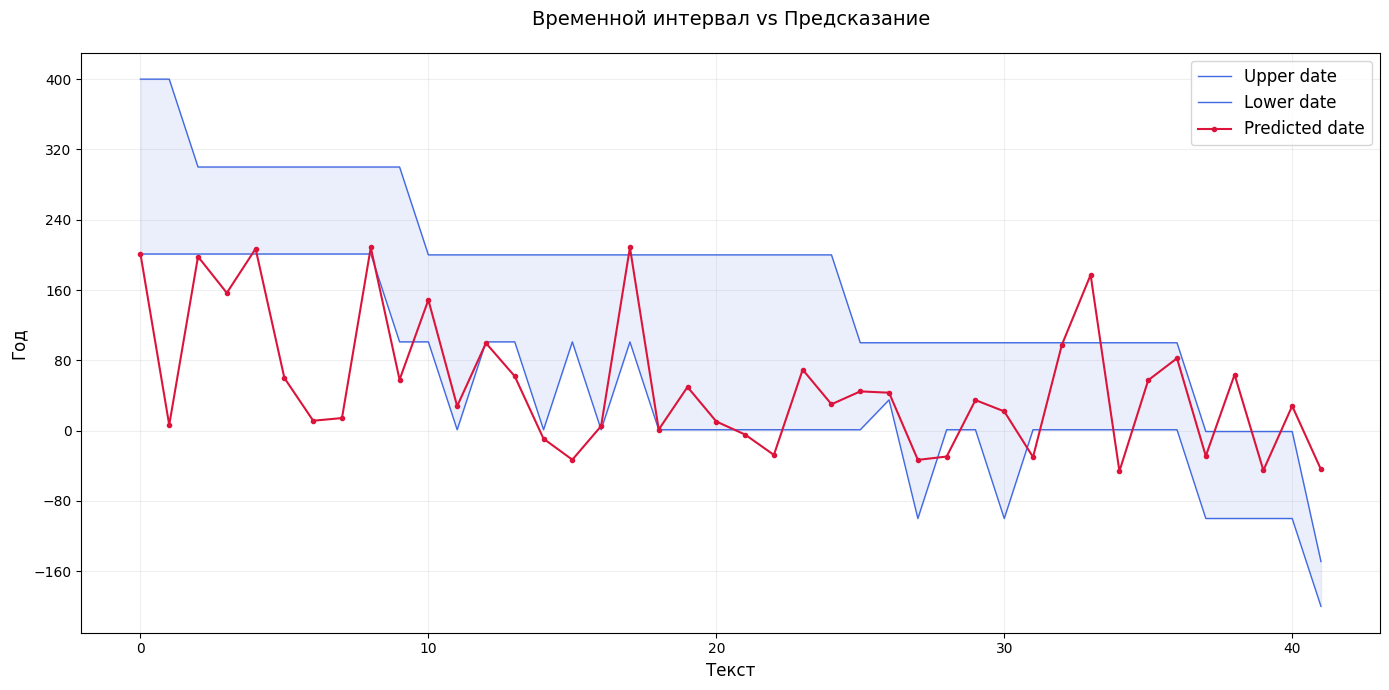

In [98]:
# 2bc - 3ad
plot_interval_graph(stack_dated_ise_prose)

In [196]:
output_path = '/content/drive/MyDrive/DIPLOMA/CORPORA/FINAL_TRAIN/final_train.csv'
new_final_ise.to_csv(output_path, index=False, encoding='utf-8-sig')

output_path = '/content/drive/MyDrive/DIPLOMA/CORPORA/FINAL_TRAIN/final_fragmented_train.csv'
balanced_final_ise.to_csv(output_path, index=False, encoding='utf-8-sig')

output_path = '/content/drive/MyDrive/DIPLOMA/CORPORA/FINAL_TEST/final_test.csv'
new_ldist_ise.to_csv(output_path, index=False, encoding='utf-8-sig')